In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression, LogisticRegression
#from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, precision_recall_curve, auc
#import xgboost

In [2]:
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:109]+sm[-109:]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids)
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids, seg

def get_array(smiles):
    x_id, x_seg = [], []
    for sm in smiles:
        a,b = get_inputs(sm)
        x_id.append(a)
        x_seg.append(b)
    return torch.tensor(x_id), torch.tensor(x_seg)

In [2]:
rates = 2**np.arange(7)/80
print(rates)

[0.0125 0.025  0.05   0.1    0.2    0.4    0.8   ]


### ECFP4

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem

def bit2np(bitvector):
    bitstring = bitvector.ToBitString()
    intmap = map(int, bitstring)
    return np.array(list(intmap))

def extract_morgan(smiles, targets):
    x,X,y = [],[],[]
    for sm,target in zip(smiles,targets):
        mol = Chem.MolFromSmiles(sm)
        if mol is None:
            print(sm)
            continue
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) # Morgan (Similar to ECFP4)
        x.append(sm)
        X.append(bit2np(fp))
        y.append(target)
    return x,np.array(X),np.array(y)

### ST, RNN, Bert

In [5]:
import torch
from pretrain_trfm import TrfmSeq2seq
from pretrain_rnn import RNNSeq2Seq
from bert import BERT
from build_vocab import WordVocab
from utils import split

pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

vocab = WordVocab.load_vocab('data/vocab.pkl')

trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 3)
trfm.load_state_dict(torch.load('.save/trfm_12_23000.pkl'))
trfm.eval()
print('Total parameters:', sum(p.numel() for p in trfm.parameters()))

rnn = RNNSeq2Seq(len(vocab), 256, len(vocab), 3)
rnn.load_state_dict(torch.load('.save/seq2seq_1.pkl'))
rnn.eval()
print('Total parameters:', sum(p.numel() for p in rnn.parameters()))

bert = BERT(len(vocab), hidden=256, n_layers=8, attn_heads=8, dropout=0)
bert.load_state_dict(torch.load('../result/chembl/ep00_it010000.pkl'))
bert.eval()
print('Total parameters:', sum(p.numel() for p in bert.parameters()))

Total parameters: 4245037
Total parameters: 4713517
Total parameters: 6330368


### GraphConv

In [3]:
import os
import deepchem as dc
from deepchem.models.tensorgraph.models.graph_models import GraphConvModel

# Evaluation

In [81]:
def evaluate_mlp_regression(X, y, rate, n_repeats):
    r2, rmse = np.empty(n_repeats), np.empty(n_repeats)
    for i in range(n_repeats):
        reg = MLPRegressor(max_iter=1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-rate)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        r2[i] = r2_score(y_pred, y_test)
        rmse[i] = mean_squared_error(y_pred, y_test)**0.5
    ret = {}
    ret['r2 mean'] = np.mean(r2)
    ret['r2 std'] = np.std(r2)
    ret['rmse mean'] = np.mean(rmse)
    ret['rmse std'] = np.std(rmse)
    return ret

def evaluate_mlp_classification(X, y, rate, n_repeats):
    auc = np.empty(n_repeats)
    for i in range(n_repeats):
        clf = MLPClassifier(max_iter=1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-rate, stratify=y)
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
        auc[i] = roc_auc_score(y_test, y_score[:,1])
    ret = {}
    ret['auc mean'] = np.mean(auc)
    ret['auc std'] = np.mean(np.std(auc, axis=0))
    return ret

def evaluate_mlp_classification_multi(X, rate, n_repeats):
    auc = np.empty(n_repeats)
    for i in range(n_repeats):
        _auc = np.empty(len(KEYS))
        for j,key in enumerate(KEYS):
            X_dr = X[df[key].notna()]
            y_dr = df[key].dropna().values
            clf = MLPClassifier(max_iter=1000)
            X_train, X_test, y_train, y_test = train_test_split(X_dr, y_dr, test_size=1-rate, stratify=y_dr)
            clf.fit(X_train, y_train)
            y_score = clf.predict_proba(X_test)
            _auc[j] = roc_auc_score(y_test, y_score[:,1])
        auc[i] = np.mean(_auc)
    ret = {}
    ret['auc mean'] = np.mean(auc)
    ret['auc std'] = np.std(auc)
    return ret

def evaluate_mlp_classification_multi_prc(X, rate, n_repeats):
    aucs = np.empty(n_repeats)
    for i in range(n_repeats):
        _aucs = np.empty(len(KEYS))
        for j,key in enumerate(KEYS):
            X_dr = X[df[key].notna()]
            y_dr = df[key].dropna().values
            clf = MLPClassifier(max_iter=1000)
            X_train, X_test, y_train, y_test = train_test_split(X_dr, y_dr, test_size=1-rate, stratify=y_dr)
            clf.fit(X_train, y_train)
            y_score = clf.predict_proba(X_test)
            precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])
            _aucs[j] = auc(recall, precision)
        aucs[i] = np.mean(_aucs)
    ret = {}
    ret['auc mean'] = np.mean(aucs)
    ret['auc std'] = np.std(aucs)
    return ret

In [6]:
def evaluate_gc_reg(dataset, rate, n_repeats):
    r2, rmse = np.empty(n_repeats), np.empty(n_repeats)
    for i in range(n_repeats):
        reg = GraphConvModel(n_tasks=1, batch_size=64, mode='regression')
        splitter = dc.splits.RandomSplitter()
        train, val, _ = splitter.train_valid_test_split(dataset, frac_train=rate, frac_valid=1-rate, frac_test=0)
        reg.fit(train)
        metrics = [dc.metrics.Metric(dc.metrics.r2_score), dc.metrics.Metric(dc.metrics.rms_score)]
        scores = reg.evaluate(val, metrics)
        r2[i] = scores['r2_score']
        rmse[i] = scores['rms_score']
    ret = {}
    ret['r2 mean'] = np.mean(r2)
    ret['r2 std'] = np.std(r2)
    ret['rmse mean'] = np.mean(rmse)
    ret['rmse std'] = np.std(rmse)
    return ret

def evaluate_classification_single_dc(dataset, rate, n_repeats):
    aucs = np.empty(n_repeats)
    for i in range(n_repeats):
        clf = GraphConvModel(n_tasks=1, batch_size=64, mode='classification')
        splitter = dc.splits.RandomStratifiedSplitter()
        train, val, _ = splitter.train_valid_test_split(dataset, frac_train=rate, frac_valid=1-rate, frac_test=0)
        clf.fit(train)
        metrics = [dc.metrics.Metric(dc.metrics.roc_auc_score)]
        scores = clf.evaluate(val, metrics)
        aucs[i] = scores['roc_auc_score']
    ret = {}
    ret['auc mean'] = np.mean(aucs)
    ret['auc std'] = np.std(aucs)
    return ret

def evaluate_classification_multi_dc(dataset, rate, n_repeats):
    auc = np.empty(n_repeats)
    for i in range(n_repeats):
        clf = GraphConvModel(n_tasks=len(KEYS), batch_size=64, mode='classification')
        splitter = dc.splits.RandomStratifiedSplitter()
        train, val, _ = splitter.train_valid_test_split(dataset, frac_train=rate, frac_valid=1-rate, frac_test=0)
        clf.fit(train)
        metrics = [dc.metrics.Metric(dc.metrics.roc_auc_score)]
        auc[i] = np.mean(clf.evaluate(val, metrics)['roc_auc_score'])
    ret = {}
    ret['auc mean'] = np.mean(auc)
    ret['auc std'] = np.std(auc)
    return ret

def evaluate_classification_multi_dc_prc(dataset, rate, n_repeats):
    auc = np.empty(n_repeats)
    for i in range(n_repeats):
        clf = GraphConvModel(n_tasks=len(KEYS), batch_size=64, mode='classification')
        splitter = dc.splits.RandomStratifiedSplitter()
        train, val, _ = splitter.train_valid_test_split(dataset, frac_train=rate, frac_valid=1-rate, frac_test=0)
        clf.fit(train)
        metrics = [dc.metrics.Metric(dc.metrics.prc_auc_score)]
        auc[i] = np.mean(clf.evaluate(val, metrics)['prc_auc_score'])
    ret = {}
    ret['auc mean'] = np.mean(auc)
    ret['auc std'] = np.std(auc)
    return ret


## ESOL

In [22]:
df = pd.read_csv('data/esol.csv')
print(df.shape)
df.head()

(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [6]:
x = df['smiles'].values
y = df['measured log solubility in mols per litre'].values

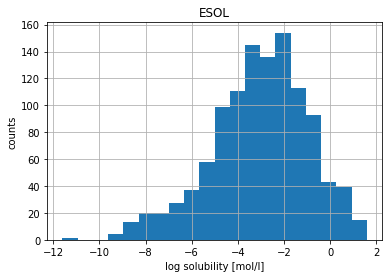

In [8]:
plt.hist(y, bins=20)
plt.xlabel('log solubility [mol/l]')
plt.ylabel('counts')
plt.title('ESOL')
plt.grid()
plt.show()

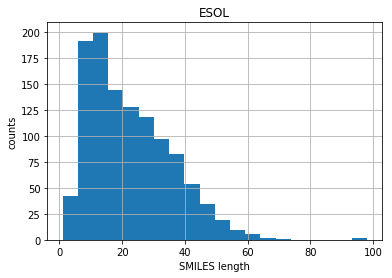

In [9]:
plt.hist(list(map(len, x)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('ESOL')
plt.grid()
plt.show()

### ST

In [23]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

There are 1128 molecules. It will take a little time.
(1128, 1024)


In [24]:
for rate in rates:
    score_dic = evaluate_mlp_regression(X, df['measured log solubility in mols per litre'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'r2 mean': -0.9415211583946711, 'r2 std': 1.318261575180566, 'rmse mean': 1.7908540396408246, 'rmse std': 0.25921653824603286}
0.025 {'r2 mean': 0.21987364024785078, 'r2 std': 0.26423711932535426, 'rmse mean': 1.410556424185161, 'rmse std': 0.1619803398915317}
0.05 {'r2 mean': 0.5128095467248189, 'r2 std': 0.1132851494485317, 'rmse mean': 1.234851956578455, 'rmse std': 0.07711254483544838}
0.1 {'r2 mean': 0.7058795568941922, 'r2 std': 0.03971447217797195, 'rmse mean': 1.0560405630256362, 'rmse std': 0.05393620743155319}
0.2 {'r2 mean': 0.7866785226815878, 'r2 std': 0.017868447395329307, 'rmse mean': 0.917584585105155, 'rmse std': 0.03221614644383914}
0.4 {'r2 mean': 0.8296558843447276, 'r2 std': 0.014470207869228075, 'rmse mean': 0.8354456598643283, 'rmse std': 0.02723549825579435}
0.8 {'r2 mean': 0.8486505017697061, 'r2 std': 0.020569941384336946, 'rmse mean': 0.761559990373766, 'rmse std': 0.031738224491864524}


### ECFP4

In [25]:
x,X,y = extract_morgan(df['smiles'].values,df['measured log solubility in mols per litre'].values)
print(len(X), len(y))

1128 1128


In [26]:
for rate in rates:
    score_dic = evaluate_mlp_regression(X, y, rate, 20)
    print(rate, score_dic)

0.0125 {'r2 mean': -4.7402112859348495, 'r2 std': 3.1798477948327104, 'rmse mean': 2.188672097366932, 'rmse std': 0.18940337551323744}
0.025 {'r2 mean': -1.384854403530391, 'r2 std': 0.9081951082252677, 'rmse mean': 2.0080312778492266, 'rmse std': 0.15757048826985784}
0.05 {'r2 mean': -0.5985494464085359, 'r2 std': 0.38650140129593413, 'rmse mean': 1.7864592440979798, 'rmse std': 0.10786081803605932}
0.1 {'r2 mean': -0.02718075663062469, 'r2 std': 0.2135168394311371, 'rmse mean': 1.7065199955745922, 'rmse std': 0.09770963048160494}
0.2 {'r2 mean': 0.260069398629162, 'r2 std': 0.11817211221207023, 'rmse mean': 1.5906690083311514, 'rmse std': 0.08374865657744206}
0.4 {'r2 mean': 0.4614631358425701, 'r2 std': 0.04028213510301852, 'rmse mean': 1.4976970335858346, 'rmse std': 0.0612324267460719}
0.8 {'r2 mean': 0.5507400136089835, 'r2 std': 0.061647391891406826, 'rmse mean': 1.4092443428232408, 'rmse std': 0.10031545693821599}


### RNN Seq2seq

In [27]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = rnn.encode(torch.t(xid))
print(X.shape)

There are 1128 molecules. It will take a little time.
(1128, 1024)


In [28]:
# .save/seq2seq_1.pkl teacher force=0.5
for rate in rates:
    score_dic = evaluate_mlp_regression(X, df['measured log solubility in mols per litre'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'r2 mean': -0.6576655351343479, 'r2 std': 0.8680374730965782, 'rmse mean': 1.834342726508901, 'rmse std': 0.21592843037541112}
0.025 {'r2 mean': 0.14646331766402304, 'r2 std': 0.2236021043686714, 'rmse mean': 1.6208138023522753, 'rmse std': 0.1268105200308446}
0.05 {'r2 mean': 0.41538372045048283, 'r2 std': 0.11580891603843564, 'rmse mean': 1.5152292646131922, 'rmse std': 0.1363634279973064}
0.1 {'r2 mean': 0.6089665447946749, 'r2 std': 0.06490939719166545, 'rmse mean': 1.2774097842323777, 'rmse std': 0.06573541382128653}
0.2 {'r2 mean': 0.6437542811598538, 'r2 std': 0.051977240501511576, 'rmse mean': 1.1091943179563248, 'rmse std': 0.05354884488129093}
0.4 {'r2 mean': 0.7235049897986274, 'r2 std': 0.04045275472829479, 'rmse mean': 0.986976386963035, 'rmse std': 0.0655700862348413}
0.8 {'r2 mean': 0.7906370184206036, 'r2 std': 0.043821997826166144, 'rmse mean': 0.8767984719438366, 'rmse std': 0.08130190297818693}


### GraphConv

In [19]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks=['measured log solubility in mols per litre'],
      smiles_field='smiles',
      featurizer=featurizer)
dataset = loader.featurize('data/esol.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/esol.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 3.413 s
TIMING: dataset construction took 4.138 s
Loading dataset from disk.


In [20]:
for rate in rates:
    score_dic = evaluate_gc_reg(dataset, rate, 20)
    print(rate, score_dic)

TIMING: dataset construction took 0.326 s
Loading dataset from disk.
TIMING: dataset construction took 0.955 s
Loading dataset from disk.
TIMING: dataset construction took 0.005 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.12216385857213707]
computed_metrics: [1.9672467276040275]
TIMING: dataset construction took 0.322 s
Loading dataset from disk.
TIMING: dataset construction took 0.983 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.21144216561338336]
computed_metrics: [1.8568643141462622]
TIMING: dataset construction took 0.316 s
Loading dataset from disk.
TIMING: dataset construction took 0.968 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.08735430859160853]
computed_metrics: [2.001129635932045]
TIMING: dataset construction took 0.322 s
Loading dataset from disk.
TIMING: dataset construction took 0.977 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.12880704715369817]
computed_metrics: [1.9643238207532052]
TIMING: dataset construction took 0.320 s
Loading dataset from d

TIMING: dataset construction took 0.327 s
Loading dataset from disk.
TIMING: dataset construction took 1.404 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.09163342154529941]
computed_metrics: [1.9945929512596376]
TIMING: dataset construction took 0.809 s
Loading dataset from disk.
TIMING: dataset construction took 0.967 s
Loading dataset from disk.
TIMING: dataset construction took 0.005 s
Loading dataset from disk.
computed_metrics: [-0.02118330760024567]
computed_metrics: [2.1191318814209983]
TIMING: dataset construction took 0.330 s
Loading dataset from disk.
TIMING: dataset construction took 0.975 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.12859159052620017]
computed_metrics: [1.9593566212102091]
TIMING: dataset construction took 0.900 s
Loading dataset from disk.
TIMING: dataset construction took 0.997 s
Loading dataset from disk.
TIM

TIMING: dataset construction took 0.956 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.16422236028735604]
computed_metrics: [1.9220562886219905]
TIMING: dataset construction took 0.349 s
Loading dataset from disk.
TIMING: dataset construction took 1.424 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.016460746785074698]
computed_metrics: [2.0819278077933783]
TIMING: dataset construction took 0.346 s
Loading dataset from disk.
TIMING: dataset construction took 0.951 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.12874330518521993]
computed_metrics: [1.9598420180361118]
0.05 {'r2 std': 0.05926625731698256, 'rmse mean': 1.980477834175543, 'rmse std': 0.06386098036042964, 'r2 mean': 0.10292860963188007}
TIMING: dataset construction took 0.372 s
Loading dataset from disk.
TIMING:

TIMING: dataset construction took 0.846 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.31818090996918547]
computed_metrics: [1.7114421697178925]
TIMING: dataset construction took 0.444 s
Loading dataset from disk.
TIMING: dataset construction took 0.853 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.499919012666446]
computed_metrics: [1.486125391485061]
TIMING: dataset construction took 0.468 s
Loading dataset from disk.
TIMING: dataset construction took 0.865 s
Loading dataset from disk.
TIMING: dataset construction took 0.004 s
Loading dataset from disk.
computed_metrics: [0.49436152406709055]
computed_metrics: [1.4729093566561635]
TIMING: dataset construction took 0.450 s
Loading dataset from disk.
TIMING: dataset construction took 0.862 s
Loading dataset from disk.
TIMING: dataset construction took 0.004 s
Loading dataset from disk.
compute

computed_metrics: [0.6653060553519186]
computed_metrics: [1.2104658886838866]
TIMING: dataset construction took 0.575 s
Loading dataset from disk.
TIMING: dataset construction took 0.709 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.6570110663616633]
computed_metrics: [1.2057721592186088]
TIMING: dataset construction took 0.585 s
Loading dataset from disk.
TIMING: dataset construction took 0.720 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.6537119928204931]
computed_metrics: [1.2155161473797156]
TIMING: dataset construction took 0.571 s
Loading dataset from disk.
TIMING: dataset construction took 0.709 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.6000235698377621]
computed_metrics: [1.322732347647415]
TIMING: dataset construction took 0.569 s
Loading dataset from disk.

### BERT

In [29]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, x_seg = get_array(x_split)
X = bert.encode(xid, x_seg)
print(X.shape)

There are 1128 molecules. It will take a little time.
(1128, 1024)


In [30]:
for rate in rates:
    score_dic = evaluate_mlp_regression(X, df['measured log solubility in mols per litre'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'r2 mean': -0.4218462598319155, 'r2 std': 1.12853220433728, 'rmse mean': 1.8052634864354444, 'rmse std': 0.20438272367625782}
0.025 {'r2 mean': 0.32471180816709816, 'r2 std': 0.2468824590116601, 'rmse mean': 1.5369117436060828, 'rmse std': 0.17608701970619678}
0.05 {'r2 mean': 0.5334642440236695, 'r2 std': 0.1092973853906982, 'rmse mean': 1.3221119866010917, 'rmse std': 0.07127253124107574}


/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.1 {'r2 mean': -0.9310922138484308, 'r2 std': 5.276265447966326, 'rmse mean': 1.3095256093518166, 'rmse std': 0.48243167949379884}
0.2 {'r2 mean': 0.5688103712394028, 'r2 std': 0.05505722514619573, 'rmse mean': 1.1528883875727645, 'rmse std': 0.05836515215097479}
0.4 {'r2 mean': 0.6440640882746392, 'r2 std': 0.05735699050993663, 'rmse mean': 1.0766792279748891, 'rmse std': 0.07766064735586084}
0.8 {'r2 mean': 0.7268476273394718, 'r2 std': 0.06532608897634908, 'rmse mean': 0.9441091512413504, 'rmse std': 0.08121336523946884}


## FreeSolv

In [31]:
df = pd.read_csv('data/freesolv.csv')
print(df.shape)
df.head()

(642, 4)


,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


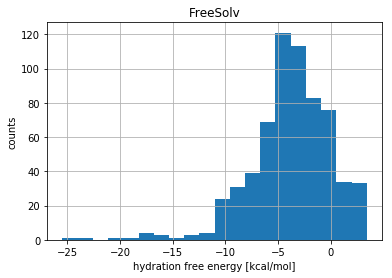

In [39]:
plt.hist(df['expt'].values, bins=20)
plt.xlabel('hydration free energy [kcal/mol]')
plt.ylabel('counts')
plt.title('FreeSolv')
plt.grid()
plt.show()

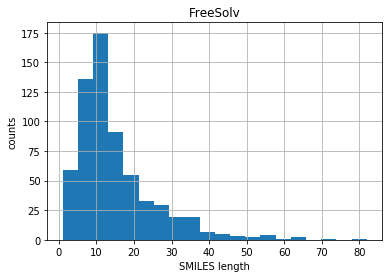

In [34]:
plt.hist(list(map(len, df['smiles'].values)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('FreeSolv')
plt.grid()
plt.show()

### ST

In [32]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

There are 642 molecules. It will take a little time.
(642, 1024)


In [33]:
for rate in rates:
    score_dic = evaluate_mlp_regression(X, df['expt'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'r2 mean': -2.576038848307165, 'r2 std': 3.1823582514133255, 'rmse mean': 3.563285984573214, 'rmse std': 0.5203207480476947}
0.025 {'r2 mean': -0.17155490859900016, 'r2 std': 0.6497953698039862, 'rmse mean': 3.017973895559536, 'rmse std': 0.26276075872191623}
0.05 {'r2 mean': 0.16950231130627935, 'r2 std': 0.30159171397738704, 'rmse mean': 2.708900454757266, 'rmse std': 0.17872391432042722}
0.1 {'r2 mean': 0.5122244255315207, 'r2 std': 0.1402954987278971, 'rmse mean': 2.2807329472406654, 'rmse std': 0.23637379910082748}
0.2 {'r2 mean': 0.6388957316544357, 'r2 std': 0.09057368881510199, 'rmse mean': 2.0964547983650728, 'rmse std': 0.1717243453332883}
0.4 {'r2 mean': 0.7494189701158778, 'r2 std': 0.06984317995358243, 'rmse mean': 1.752377868341597, 'rmse std': 0.17197715801020766}
0.8 {'r2 mean': 0.822875714266269, 'r2 std': 0.03297363529141653, 'rmse mean': 1.5651345339616252, 'rmse std': 0.12273727507018312}


### ECFP4

In [34]:
x,X,y = extract_morgan(df['smiles'].values, df['expt'].values)
print(len(X), len(y))

642 642


In [35]:
for rate in rates:
    score_dic = evaluate_mlp_regression(X, df['expt'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'r2 mean': -8.249829514981576, 'r2 std': 5.155942727909447, 'rmse mean': 3.7731531040381254, 'rmse std': 0.29264932692192236}
0.025 {'r2 mean': -6.608540315598347, 'r2 std': 5.124543664210768, 'rmse mean': 3.741884029649259, 'rmse std': 0.3574978874792624}
0.05 {'r2 mean': -2.7724693760067467, 'r2 std': 1.141712601756891, 'rmse mean': 3.495406561344887, 'rmse std': 0.2279989969923611}
0.1 {'r2 mean': -0.6963197306733483, 'r2 std': 0.5087077522223022, 'rmse mean': 3.0379101054168234, 'rmse std': 0.18784217858626967}
0.2 {'r2 mean': 0.043597037881702425, 'r2 std': 0.2739795675995701, 'rmse mean': 2.701847249065082, 'rmse std': 0.22920512171513513}
0.4 {'r2 mean': 0.43908453408517223, 'r2 std': 0.2005841073724038, 'rmse mean': 2.319037238029083, 'rmse std': 0.26535652438656315}
0.8 {'r2 mean': 0.5825636720130783, 'r2 std': 0.15797881956329185, 'rmse mean': 2.229430763600421, 'rmse std': 0.32842121152455583}


### RNN Seq2seq

In [36]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = rnn.encode(torch.t(xid))
print(X.shape)

There are 642 molecules. It will take a little time.
(642, 1024)


In [37]:
# .save/seq2seq_1.pkl teacher force=0.5
for rate in rates:
    score_dic = evaluate_mlp_regression(X, df['expt'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'r2 mean': -1.615745596115613, 'r2 std': 1.30363754084909, 'rmse mean': 3.7720689486018535, 'rmse std': 0.33779178449363345}
0.025 {'r2 mean': -0.796930834007093, 'r2 std': 1.0379189493195213, 'rmse mean': 3.8487613943533794, 'rmse std': 0.40999173919011167}
0.05 {'r2 mean': -0.04056501696922476, 'r2 std': 0.3129901234962947, 'rmse mean': 3.461297109364863, 'rmse std': 0.31524635484683333}
0.1 {'r2 mean': 0.27739675155942656, 'r2 std': 0.1898138070408286, 'rmse mean': 2.939124192135112, 'rmse std': 0.1752893508268099}
0.2 {'r2 mean': 0.46804150937809774, 'r2 std': 0.09206445928415609, 'rmse mean': 2.5907312336675123, 'rmse std': 0.16733094825672618}
0.4 {'r2 mean': 0.5422847453216633, 'r2 std': 0.08811908127393377, 'rmse mean': 2.2139400314097264, 'rmse std': 0.1312437049628559}
0.8 {'r2 mean': 0.6018561755802786, 'r2 std': 0.09849124916576087, 'rmse mean': 2.0804367851436165, 'rmse std': 0.22935096310462355}


### GraphConv

In [21]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks=['expt'],
      smiles_field='smiles',
      featurizer=featurizer)
dataset = loader.featurize('data/freesolv.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/freesolv.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 1.607 s
TIMING: dataset construction took 1.932 s
Loading dataset from disk.


In [22]:
for rate in rates:
    score_dic = evaluate_gc_reg(dataset, rate, 20)
    print(rate, score_dic)

TIMING: dataset construction took 0.151 s
Loading dataset from disk.
TIMING: dataset construction took 0.436 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [-0.04720810377762352]
computed_metrics: [3.934380257184632]
TIMING: dataset construction took 0.152 s
Loading dataset from disk.
TIMING: dataset construction took 0.448 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.09895105442204988]
computed_metrics: [3.667499628855471]
TIMING: dataset construction took 0.160 s
Loading dataset from disk.
TIMING: dataset construction took 0.898 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [-0.3726662316219329]
computed_metrics: [4.507834260202535]
TIMING: dataset construction took 0.150 s
Loading dataset from disk.
TIMING: dataset construction took 0.442 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.06028892195304725]
computed_metrics: [3.7384051825049727]
TIMING: dataset construction took 0.149 s
Loading dataset from di

TIMING: dataset construction took 0.156 s
Loading dataset from disk.
TIMING: dataset construction took 0.440 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.10411065799780628]
computed_metrics: [3.656488096509271]
TIMING: dataset construction took 0.155 s
Loading dataset from disk.
TIMING: dataset construction took 0.448 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [-0.11424667372856767]
computed_metrics: [4.08996800878913]
TIMING: dataset construction took 0.156 s
Loading dataset from disk.
TIMING: dataset construction took 0.440 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.08679916264963372]
computed_metrics: [3.6828643513355233]
TIMING: dataset construction took 0.158 s
Loading dataset from disk.
TIMING: dataset construction took 0.441 s
Loading dataset from disk.
TIMING

TIMING: dataset construction took 0.444 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.11571419501326552]
computed_metrics: [3.6673220030924276]
TIMING: dataset construction took 0.163 s
Loading dataset from disk.
TIMING: dataset construction took 0.432 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.12286388148407035]
computed_metrics: [3.6218104843317733]
TIMING: dataset construction took 0.165 s
Loading dataset from disk.
TIMING: dataset construction took 0.433 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.1265659338166446]
computed_metrics: [3.5721119836536155]
0.05 {'r2 std': 0.055684798942738874, 'rmse mean': 3.6843657391379785, 'rmse std': 0.1092416676948551, 'r2 mean': 0.08290928326789651}
TIMING: dataset construction took 0.187 s
Loading dataset from disk.
TIMING: 

TIMING: dataset construction took 0.382 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.28735897072314676]
computed_metrics: [3.2103428054406122]
TIMING: dataset construction took 0.207 s
Loading dataset from disk.
TIMING: dataset construction took 0.828 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.18229163813161675]
computed_metrics: [3.449196098944544]
TIMING: dataset construction took 0.205 s
Loading dataset from disk.
TIMING: dataset construction took 0.382 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.06493485517466502]
computed_metrics: [3.6258692527114644]
TIMING: dataset construction took 0.208 s
Loading dataset from disk.
TIMING: dataset construction took 0.386 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
compu

computed_metrics: [0.27121833725076006]
computed_metrics: [3.22762693111487]
TIMING: dataset construction took 0.264 s
Loading dataset from disk.
TIMING: dataset construction took 0.323 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.18665717880543964]
computed_metrics: [3.493619031733441]
TIMING: dataset construction took 0.267 s
Loading dataset from disk.
TIMING: dataset construction took 0.325 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.3537810225942759]
computed_metrics: [3.0327517032793034]
TIMING: dataset construction took 0.273 s
Loading dataset from disk.
TIMING: dataset construction took 0.322 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.19989410472805225]
computed_metrics: [3.25242804947906]
TIMING: dataset construction took 0.274 s
Loading dataset from disk.


### BERT

In [38]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, x_seg = get_array(x_split)
X = bert.encode(xid, x_seg)
print(X.shape)

There are 642 molecules. It will take a little time.
(642, 1024)


In [39]:
for rate in rates:
    score_dic = evaluate_mlp_regression(X, df['expt'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'r2 mean': -1.377142007663866, 'r2 std': 1.5487518294971385, 'rmse mean': 3.6786090757959555, 'rmse std': 0.4631547029092409}
0.025 {'r2 mean': -0.5120257814567901, 'r2 std': 0.9416595926594606, 'rmse mean': 3.521783696845348, 'rmse std': 0.48660933002580875}
0.05 {'r2 mean': 0.09436097224372444, 'r2 std': 0.25540669155947027, 'rmse mean': 3.231243059431307, 'rmse std': 0.3850266360269509}
0.1 {'r2 mean': 0.25376523340854945, 'r2 std': 0.3189437279151671, 'rmse mean': 2.874012673776751, 'rmse std': 0.3734029890427589}
0.2 {'r2 mean': 0.4903933724769975, 'r2 std': 0.09405450015168304, 'rmse mean': 2.418033377941923, 'rmse std': 0.14287733130912234}
0.4 {'r2 mean': 0.3989386970916471, 'r2 std': 0.1935410242545029, 'rmse mean': 2.314307600743562, 'rmse std': 0.26585326818512867}
0.8 {'r2 mean': 0.4790413721629361, 'r2 std': 0.23232464064952593, 'rmse mean': 2.194148467402316, 'rmse std': 0.4054882828477564}


## Lipophilicity

In [41]:
df = pd.read_csv('data/lipo.csv')
print(df.shape)
df.head()

(4200, 3)


,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [7]:
x = df['smiles'].values
y = df['exp'].values

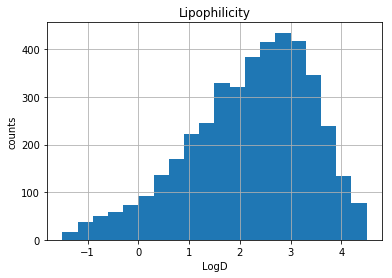

In [8]:
plt.hist(df['exp'].values, bins=20)
plt.xlabel('LogD')
plt.ylabel('counts')
plt.title('Lipophilicity')
plt.grid()
plt.show()

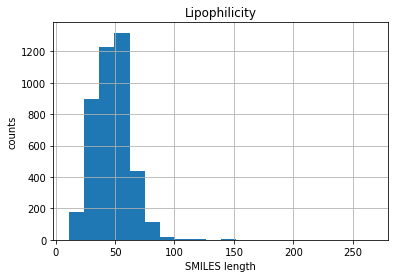

In [9]:
plt.hist(list(map(len, df['smiles'].values)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('Lipophilicity')
plt.grid()
plt.show()

### ST

In [42]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

SMILES is too long (251)
SMILES is too long (267)
There are 4200 molecules. It will take a little time.
(4200, 1024)


In [43]:
for rate in rates:
    score_dic = evaluate_mlp_regression(X, df['exp'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'r2 mean': -0.8554874389638881, 'r2 std': 0.32161227959529265, 'rmse mean': 1.362699506951056, 'rmse std': 0.05460045647733459}
0.025 {'r2 mean': -0.5750715666569235, 'r2 std': 0.23125835199131015, 'rmse mean': 1.3158578150223024, 'rmse std': 0.05672943297760686}
0.05 {'r2 mean': -0.9279695224423072, 'r2 std': 0.4063446132498258, 'rmse mean': 1.1688094071981658, 'rmse std': 0.036778880094887605}
0.1 {'r2 mean': -0.5248859235512959, 'r2 std': 0.21055122799288017, 'rmse mean': 1.1393706154991743, 'rmse std': 0.050638470682191}
0.2 {'r2 mean': -0.17559338156403226, 'r2 std': 0.08010647791343767, 'rmse mean': 1.1237959263208617, 'rmse std': 0.02691822224201018}
0.4 {'r2 mean': -0.06963317783051187, 'r2 std': 0.0718535871852915, 'rmse mean': 1.0619550410370049, 'rmse std': 0.03224306817213578}
0.8 {'r2 mean': 0.09709484977886422, 'r2 std': 0.10567680471645093, 'rmse mean': 1.010608821729128, 'rmse std': 0.043589502538406835}


### ECFP4

In [44]:
x,X,y = extract_morgan(df['smiles'].values, df['exp'].values)
print(len(X), len(y))

4200 4200


In [45]:
for rate in rates:
    score_dic = evaluate_mlp_regression(X, df['exp'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'r2 mean': -3.0185287752744396, 'r2 std': 0.5130118823343891, 'rmse mean': 1.2557652975680362, 'rmse std': 0.03034256405123591}
0.025 {'r2 mean': -1.8354626225369692, 'r2 std': 0.4250827781919392, 'rmse mean': 1.210881631299388, 'rmse std': 0.02872279543186055}
0.05 {'r2 mean': -1.1133476482277398, 'r2 std': 0.1432101923255158, 'rmse mean': 1.168687033147242, 'rmse std': 0.02132440870064626}
0.1 {'r2 mean': -0.5659144583266428, 'r2 std': 0.10375012951843238, 'rmse mean': 1.1244923947071837, 'rmse std': 0.02834369440099355}
0.2 {'r2 mean': -0.16426510220074525, 'r2 std': 0.0692734606243446, 'rmse mean': 1.0509783346213428, 'rmse std': 0.024879478637870336}
0.4 {'r2 mean': 0.10966450577713807, 'r2 std': 0.03768060588141019, 'rmse mean': 0.9624406906992293, 'rmse std': 0.014897447369411924}
0.8 {'r2 mean': 0.3328114195722362, 'r2 std': 0.052225416452739225, 'rmse mean': 0.8567831513616205, 'rmse std': 0.023231786764762515}


### RNN Seq2seq

In [46]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = rnn.encode(torch.t(xid))
print(X.shape)

SMILES is too long (251)
SMILES is too long (267)
There are 4200 molecules. It will take a little time.
(4200, 1024)


In [47]:
for rate in rates:
    score_dic = evaluate_mlp_regression(X, df['exp'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'r2 mean': -0.6767598752879095, 'r2 std': 0.20420736919906438, 'rmse mean': 1.566043721959609, 'rmse std': 0.13437421315838807}
0.025 {'r2 mean': -0.5904476018764735, 'r2 std': 0.21219172196421496, 'rmse mean': 1.505079025648835, 'rmse std': 0.07851203718146249}
0.05 {'r2 mean': -3.086272351751131, 'r2 std': 1.2909720904350117, 'rmse mean': 1.213664605537772, 'rmse std': 0.07078734631546009}
0.1 {'r2 mean': -2.3869797586546655, 'r2 std': 1.1326738671501444, 'rmse mean': 1.1488548246203958, 'rmse std': 0.0401735583332994}
0.2 {'r2 mean': -1.4420690771889635, 'r2 std': 0.9802082867677682, 'rmse mean': 1.092209199434006, 'rmse std': 0.029197762177377545}
0.4 {'r2 mean': -0.42145289710563605, 'r2 std': 0.24045040351005245, 'rmse mean': 1.0369616318212893, 'rmse std': 0.03770878501450758}
0.8 {'r2 mean': -0.16762926529149724, 'r2 std': 0.1905362307779292, 'rmse mean': 0.9703464504060376, 'rmse std': 0.042637116246321945}


### GraphConv

In [23]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks=['exp'],
      smiles_field='smiles',
      featurizer=featurizer)
dataset = loader.featurize('data/lipo.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/lipo.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
TIMING: featurizing shard 0 took 19.407 s
TIMING: dataset construction took 23.985 s
Loading dataset from disk.


In [24]:
for rate in rates:
    score_dic = evaluate_gc_reg(dataset, rate, 20)
    print(rate, score_dic)

TIMING: dataset construction took 1.977 s
Loading dataset from disk.
TIMING: dataset construction took 6.282 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [-0.0214850767150907]
computed_metrics: [1.2150158210981377]
TIMING: dataset construction took 2.377 s
Loading dataset from disk.
TIMING: dataset construction took 6.412 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [-0.0186092157271609]
computed_metrics: [1.2155066903133847]
TIMING: dataset construction took 2.404 s
Loading dataset from disk.
TIMING: dataset construction took 6.620 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [-0.5216623386900778]
computed_metrics: [1.4862374392144801]
TIMING: dataset construction took 2.354 s
Loading dataset from disk.
TIMING: dataset construction took 6.721 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [-0.37674536784179824]
computed_metrics: [1.4118750131561493]
TIMING: dataset construction took 2.577 s
Loading dataset from

TIMING: dataset construction took 1.922 s
Loading dataset from disk.
TIMING: dataset construction took 6.658 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [-0.04614748498464105]
computed_metrics: [1.2290537613295693]
TIMING: dataset construction took 2.478 s
Loading dataset from disk.
TIMING: dataset construction took 6.412 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.041650520468933694]
computed_metrics: [1.1787443835161515]
TIMING: dataset construction took 2.519 s
Loading dataset from disk.
TIMING: dataset construction took 6.216 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.09258302946142971]
computed_metrics: [1.1465227486269531]
TIMING: dataset construction took 2.539 s
Loading dataset from disk.
TIMING: dataset construction took 6.195 s
Loading dataset from disk.
TI

TIMING: dataset construction took 6.248 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.11441283453512252]
computed_metrics: [1.1298322375118421]
TIMING: dataset construction took 2.498 s
Loading dataset from disk.
TIMING: dataset construction took 6.030 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.08966723496604034]
computed_metrics: [1.147760644699459]
TIMING: dataset construction took 2.706 s
Loading dataset from disk.
TIMING: dataset construction took 5.973 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.08835296207634658]
computed_metrics: [1.145147340938359]
0.05 {'r2 std': 0.033515839509092295, 'rmse mean': 1.1455263636356743, 'rmse std': 0.020914298344088377, 'r2 mean': 0.09308736125617714}
TIMING: dataset construction took 2.203 s
Loading dataset from disk.
TIMING:

TIMING: dataset construction took 3.261 s
Loading dataset from disk.
TIMING: dataset construction took 5.550 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.3566858307113602]
computed_metrics: [0.9659061565073636]
TIMING: dataset construction took 3.168 s
Loading dataset from disk.
TIMING: dataset construction took 5.532 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.3695396515266226]
computed_metrics: [0.9621211741084096]
TIMING: dataset construction took 2.615 s
Loading dataset from disk.
TIMING: dataset construction took 6.302 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.2837096427654977]
computed_metrics: [1.019421671056445]
TIMING: dataset construction took 3.159 s
Loading dataset from disk.
TIMING: dataset construction took 5.517 s
Loading dataset from disk.
TIMING: 

computed_metrics: [0.34743480175019736]
computed_metrics: [0.9610368111530544]
TIMING: dataset construction took 4.178 s
Loading dataset from disk.
TIMING: dataset construction took 4.538 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.4292714845230361]
computed_metrics: [0.9134758877388593]
TIMING: dataset construction took 3.553 s
Loading dataset from disk.
TIMING: dataset construction took 5.051 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.48605464809022303]
computed_metrics: [0.8679765728167751]
TIMING: dataset construction took 3.433 s
Loading dataset from disk.
TIMING: dataset construction took 4.988 s
Loading dataset from disk.
TIMING: dataset construction took 0.003 s
Loading dataset from disk.
computed_metrics: [0.48931367303074935]
computed_metrics: [0.8641372194966944]
TIMING: dataset construction took 4.146 s
Loading dataset from d

### BERT

In [48]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, x_seg = get_array(x_split)
X = bert.encode(xid, x_seg)
print(X.shape)

SMILES is too long (251)
SMILES is too long (267)
There are 4200 molecules. It will take a little time.
(4200, 1024)


In [49]:
for rate in rates:
    score_dic = evaluate_mlp_regression(X, df['exp'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'r2 mean': -14.514631770080332, 'r2 std': 23.262761105956823, 'rmse mean': 1.5080057039422914, 'rmse std': 0.4831830100914375}
0.025 {'r2 mean': -9.731499010077048, 'r2 std': 11.945902270053688, 'rmse mean': 1.3296421477000275, 'rmse std': 0.2318079700974936}
0.05 {'r2 mean': -7.564789967146569, 'r2 std': 6.13930759091004, 'rmse mean': 1.178951781021642, 'rmse std': 0.042316573476393435}
0.1 {'r2 mean': -4.497317549653632, 'r2 std': 3.2095528695781894, 'rmse mean': 1.1361189928497206, 'rmse std': 0.05584627694293891}
0.2 {'r2 mean': -3.2552865375698112, 'r2 std': 0.6604272649716593, 'rmse mean': 1.1070444850608878, 'rmse std': 0.04593653435766104}
0.4 {'r2 mean': -2.9335238929303493, 'r2 std': 0.6777809866942506, 'rmse mean': 1.1142805411790415, 'rmse std': 0.07670659554132803}
0.8 {'r2 mean': -2.432888614121183, 'r2 std': 0.3635102898586054, 'rmse mean': 1.0674099648841258, 'rmse std': 0.031432597633560454}


## MUV

In [5]:
df = pd.read_csv('data/muv.csv')
KEYS  = df.keys()[:-2]
print(df.shape)
df.head()

(93087, 19)


,MUV-466,MUV-548,MUV-600,MUV-644,MUV-652,MUV-689,MUV-692,MUV-712,MUV-713,MUV-733,MUV-737,MUV-810,MUV-832,MUV-846,MUV-852,MUV-858,MUV-859,mol_id,smiles
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,CID2999678,Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
1,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,CID2999679,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,CID2999672,COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
3,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,CID5390002,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
4,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CID2999670,NC(=O)NC(Cc1ccccc1)C(=O)O


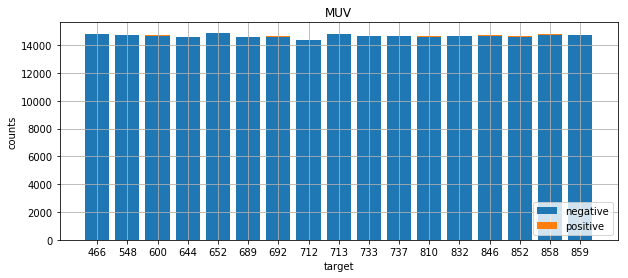

In [64]:
neg = [(df[k]==0).sum() for k in KEYS]
pos = [(df[k]==1).sum() for k in KEYS]
keys = [k[-3:] for k in KEYS]
plt.figure(figsize=(10,4))
bot = np.zeros(len(KEYS))
plt.bar(keys, neg, bottom=bot, label='negative')
bot += neg
plt.bar(keys, pos, bottom=bot, label='positive')
plt.xlabel('target')
plt.ylabel('counts')
plt.title('MUV')
plt.legend(loc='lower right')
plt.grid()
plt.show()

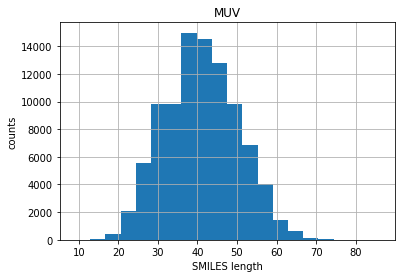

In [65]:
plt.hist(list(map(len, df['smiles'].values)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('MUV')
plt.grid()
plt.show()

### ST

In [84]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

There are 93087 molecules. It will take a little time.
(93087, 1024)


In [85]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi_prc(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.0017335375503279577, 'auc std': 8.288996720512347e-05}
0.025 {'auc mean': 0.0025805688671491417, 'auc std': 0.000670080595910785}
0.05 {'auc mean': 0.003159505491407609, 'auc std': 0.001041083363598049}
0.1 {'auc mean': 0.007896562363993064, 'auc std': 0.002325617467805242}
0.2 {'auc mean': 0.009137891290853841, 'auc std': 0.0027659502543736897}
0.4 {'auc mean': 0.01382557926523403, 'auc std': 0.005862018875758404}
0.8 {'auc mean': 0.023029825298708013, 'auc std': 0.008997661713549966}


### ECFP4

In [86]:
x,X,_ = extract_morgan(df['smiles'].values, df['smiles'].values)
print(len(X), len(X))

93087 93087


In [87]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi_prc(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.0022181961631041196, 'auc std': 4.397035321373162e-05}
0.025 {'auc mean': 0.010256923576680345, 'auc std': 0.004200252646055124}
0.05 {'auc mean': 0.009357011284886738, 'auc std': 0.0035729453685806522}
0.1 {'auc mean': 0.023985972228104942, 'auc std': 0.006940933161308397}
0.2 {'auc mean': 0.03533633524999891, 'auc std': 0.006898272998302227}
0.4 {'auc mean': 0.06218030360270412, 'auc std': 0.008688507334103052}
0.8 {'auc mean': 0.1070137217540055, 'auc std': 0.022559116213062138}


### RNNSeq2seq

In [88]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = rnn.encode(torch.t(xid))
print(X.shape)

There are 93087 molecules. It will take a little time.
(93087, 1024)


In [89]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi_prc(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.002765855247617432, 'auc std': 0.0002153396389107669}
0.025 {'auc mean': 0.0036739954143430046, 'auc std': 0.0013241874142129418}
0.05 {'auc mean': 0.004560044904293777, 'auc std': 0.0015448114068087513}
0.1 {'auc mean': 0.0074651701433578205, 'auc std': 0.00254163617852841}
0.2 {'auc mean': 0.009181132220160041, 'auc std': 0.003553903256273968}
0.4 {'auc mean': 0.012842807356186717, 'auc std': 0.003599612373533911}
0.8 {'auc mean': 0.02673075155575853, 'auc std': 0.011771354835709888}


### GraphConv

In [10]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks=list(KEYS),
      smiles_field='smiles',
      featurizer=featurizer)
dataset = loader.featurize('data/muv.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/muv.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 36.159 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 1 took 35.971 s
Loading shard 3 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 2 took 34.737 s
Loading shard 4 of size 8192.
Featurizing sample 0
Featuri

In [11]:
for rate in rates:
    score_dic = evaluate_classification_multi_dc_prc(dataset, rate, 20)
    print(rate, score_dic)

TIMING: dataset construction took 0.008 s
Loading dataset from disk.
TIMING: dataset construction took 92.344 s
Loading dataset from disk.
TIMING: dataset construction took 94.983 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.001819308877380195, 0.002320071796791683, 0.001428089147299605, 0.002019331022518054, 0.018752041993143113, 0.0053123593421431255, 0.0023752574616643964, 0.002397118727489853, 0.002711023520091168, 0.0021120606010403345, 0.0017900433170827004, 0.002064403355712182, 0.0017470317505279534, 0.002630207527539433, 0.00366482854284812, 0.0016594720337507745, 0.0021316452233823297]
TIMING: dataset construction took 0.007 s
Loading dataset from disk.
TIMING: dataset construction took 98.948 s
Loading dataset from disk.
TIMING: dataset construction took 95.682 s
Loading dataset from disk.
computed_metrics: [0.0018107924112634552, 0.0028791296220830086, 0.001430298827157826, 0.0019489873081468372, 0.001488173742469304, 0.0017876372714721455, 0.0049811293653378354, 0.0024467860405175765, 0.0013820265475071025, 0.0018179204428158233, 0.0027868526476344494, 0.0015171227795002487, 0.0015998677842446675, 0.0017210665922695633, 0.0026909821154251935, 0.0019597867779732147, 0.00224

TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 104.477 s
Loading dataset from disk.
TIMING: dataset construction took 102.141 s
Loading dataset from disk.
computed_metrics: [0.0017687807544998417, 0.0027112967317222776, 0.002088845634104667, 0.002930225663599405, 0.0037181283384153767, 0.0024729397052074657, 0.0030593651208453638, 0.0014733206076134498, 0.0025218410052403268, 0.00211182306241715, 0.0015751400386473761, 0.001944189114320964, 0.0016450966517048955, 0.0020763814433380086, 0.0014892225711585307, 0.0025653799082758265, 0.0022956045062230944]
TIMING: dataset construction took 0.008 s
Loading dataset from disk.
TIMING: dataset construction took 98.757 s
Loading dataset from disk.
TIMING: dataset construction took 99.013 s
Loading dataset from disk.
computed_metrics: [0.008169811728038608, 0.003164398016659111, 0.0014976578891715171, 0.0018889319565058597, 0.0014150984060173368, 0.0013544946804689238, 0.011579548992556145

TIMING: dataset construction took 99.267 s
Loading dataset from disk.
computed_metrics: [0.0020602000889964125, 0.0013487282799158197, 0.0024952958732263704, 0.002294645562253284, 0.002912637604804466, 0.0037490992949282815, 0.003245056405485029, 0.0014094765498914481, 0.005230358042114659, 0.0036466248956828146, 0.0029473357360503757, 0.001766001950377384, 0.002459937915155533, 0.002628367762272442, 0.0020853043009708932, 0.0017075262521873387, 0.0016173271214079575]
TIMING: dataset construction took 0.009 s
Loading dataset from disk.
TIMING: dataset construction took 96.034 s
Loading dataset from disk.
TIMING: dataset construction took 97.055 s
Loading dataset from disk.
computed_metrics: [0.0015096561523442588, 0.00133177173474629, 0.0026117134303132537, 0.001889061687481445, 0.002503822054828713, 0.0018092370226418409, 0.0017510580939973912, 0.0014062418092472934, 0.0015284345557085971, 0.001966323671802055, 0.001601527401609287, 0.0014887220917967979, 0.0023017149493690225, 0.0018

TIMING: dataset construction took 5.447 s
Loading dataset from disk.
TIMING: dataset construction took 97.501 s
Loading dataset from disk.
TIMING: dataset construction took 96.596 s
Loading dataset from disk.
computed_metrics: [0.0030033234450396267, 0.007660123582821048, 0.0022859299731073034, 0.007560371190701689, 0.009841114355821289, 0.0027843291896332664, 0.0030975492576764984, 0.003194326530393902, 0.004506913398761284, 0.0032793968504582515, 0.005000922094555194, 0.0028191978037348307, 0.004504151773941251, 0.0027824648927519987, 0.0048445933991365375, 0.0016680993260829884, 0.0019359009086683753]
TIMING: dataset construction took 3.495 s
Loading dataset from disk.
TIMING: dataset construction took 97.582 s
Loading dataset from disk.
TIMING: dataset construction took 97.779 s
Loading dataset from disk.
computed_metrics: [0.002013602753793817, 0.003474744196181328, 0.005812377972358468, 0.006740489202465389, 0.0029193073705832623, 0.002441523983862022, 0.002095978724765965, 0.002

TIMING: dataset construction took 3.874 s
Loading dataset from disk.
TIMING: dataset construction took 96.282 s
Loading dataset from disk.
TIMING: dataset construction took 97.099 s
Loading dataset from disk.
computed_metrics: [0.002978134806436359, 0.003405380776288424, 0.010844896204426671, 0.005768595423903702, 0.003311521014691958, 0.0019646615128091445, 0.0039046781990635694, 0.0025166892126966206, 0.002604217193333079, 0.0023686940158439886, 0.0025687640759184923, 0.0018584945284426696, 0.005686585255699851, 0.0026532703947907, 0.0035112732345374312, 0.0031922126828008253, 0.0012996423717110466]
TIMING: dataset construction took 4.419 s
Loading dataset from disk.
TIMING: dataset construction took 96.922 s
Loading dataset from disk.
TIMING: dataset construction took 96.537 s
Loading dataset from disk.
computed_metrics: [0.0027803285139942915, 0.0048887578175426955, 0.0032774815969184444, 0.0034872454834227826, 0.0032970474165611835, 0.003095493146488322, 0.00232960817557601, 0.003

computed_metrics: [0.0021608837938084406, 0.004872516556677142, 0.004645993633269609, 0.0024158582356423345, 0.014040980097292056, 0.0015006434395209752, 0.0030099944052083944, 0.002025136449219582, 0.007286130816424972, 0.002732577092280211, 0.0021727800633697357, 0.00460350325724598, 0.0030705826103459522, 0.0027473802028814484, 0.002513584106198331, 0.0013183316026881742, 0.001607680174518089]
TIMING: dataset construction took 7.627 s
Loading dataset from disk.
TIMING: dataset construction took 99.822 s
Loading dataset from disk.
TIMING: dataset construction took 96.456 s
Loading dataset from disk.
computed_metrics: [0.006633244967623418, 0.005053161758055518, 0.0021437607701273774, 0.0018529025628857753, 0.0039807820348612645, 0.0024305031758668667, 0.0026187104362157742, 0.002868588719276525, 0.0024091959042497725, 0.0016083794800949044, 0.007231193640893131, 0.002250661689278292, 0.004668437267436155, 0.00311866352487004, 0.005965975416973102, 0.0019318993096276047, 0.00147979120

TIMING: dataset construction took 21.858 s
Loading dataset from disk.
TIMING: dataset construction took 85.055 s
Loading dataset from disk.
TIMING: dataset construction took 80.480 s
Loading dataset from disk.
computed_metrics: [0.0025627201455866513, 0.005163119977093925, 0.0025308797256058516, 0.005155717498548553, 0.00418235951682391, 0.0032736801872209685, 0.002375540390028829, 0.0021731342710302843, 0.0035931072670043517, 0.002723634473273628, 0.0035454623794556046, 0.0025511730554315477, 0.0031070299522292484, 0.0028547424649127463, 0.0037277024251964044, 0.0016680283057020479, 0.0018350771115534532]
TIMING: dataset construction took 20.731 s
Loading dataset from disk.
TIMING: dataset construction took 82.946 s
Loading dataset from disk.
TIMING: dataset construction took 82.128 s
Loading dataset from disk.
computed_metrics: [0.00560484459440971, 0.00474468029035845, 0.0048425823831062115, 0.0017396187198416005, 0.007277240363622999, 0.002668344928103632, 0.002735144908937482, 0.0

TIMING: dataset construction took 22.134 s
Loading dataset from disk.
TIMING: dataset construction took 81.151 s
Loading dataset from disk.
TIMING: dataset construction took 81.492 s
Loading dataset from disk.
computed_metrics: [0.001829932874622296, 0.004293547120720885, 0.0024167395218083125, 0.0031233322854609634, 0.003552173023605016, 0.002783190048909691, 0.0028319867286203237, 0.003509067631870047, 0.0037974120510734476, 0.0036898315729315566, 0.004317988177195538, 0.002364091320023783, 0.005067314287943785, 0.00518609046385521, 0.009027083239392794, 0.0061890292692089, 0.003637317042878749]
TIMING: dataset construction took 18.428 s
Loading dataset from disk.
TIMING: dataset construction took 84.030 s
Loading dataset from disk.
TIMING: dataset construction took 80.672 s
Loading dataset from disk.
computed_metrics: [0.002697672321241942, 0.003889800641602246, 0.0021987923893016905, 0.004147738698045425, 0.006176302741028428, 0.0016087184101924977, 0.0021698431702718434, 0.0023865

TIMING: dataset construction took 46.274 s
Loading dataset from disk.
TIMING: dataset construction took 65.009 s
Loading dataset from disk.
TIMING: dataset construction took 69.509 s
Loading dataset from disk.
computed_metrics: [0.0026859288139766922, 0.002469552116017003, 0.0024688185717359904, 0.002822070837622384, 0.0029403294541164903, 0.002178401214229108, 0.0031458516384542242, 0.004657218838347922, 0.003064066421583529, 0.0025781556302113934, 0.0030263997382637756, 0.001996565765533349, 0.004289334633903089, 0.0025810961485091674, 0.0025665320275632983, 0.0024588372609745442, 0.0015129383311620044]
TIMING: dataset construction took 44.303 s
Loading dataset from disk.
TIMING: dataset construction took 69.215 s
Loading dataset from disk.
TIMING: dataset construction took 65.861 s
Loading dataset from disk.
computed_metrics: [0.0022634500707455546, 0.00217506578287571, 0.0030824186615414475, 0.003984195448873401, 0.0027198274989989352, 0.002293013713106284, 0.002309890908170419, 0.

TIMING: dataset construction took 99.584 s
Loading dataset from disk.
TIMING: dataset construction took 46.414 s
Loading dataset from disk.
TIMING: dataset construction took 28.023 s
Loading dataset from disk.
computed_metrics: [0.001024689414800313, 0.0016619005450509447, 0.0027109970469335553, 0.0014049215445783923, 0.004281561288947699, 0.0047337501017013, 0.0014322149755938577, 0.0022964293316352783, 0.001681268325924017, 0.0007216375627110464, 0.004096635451758525, 0.004685361168644471, 0.001136336024921802, 0.004423088203447643, 0.0016747640545051149, 0.0035315458040883155, 0.0026248917071372896]
TIMING: dataset construction took 124.221 s
Loading dataset from disk.
TIMING: dataset construction took 48.844 s
Loading dataset from disk.
TIMING: dataset construction took 24.438 s
Loading dataset from disk.
computed_metrics: [0.002200736901436857, 0.0013579677680510857, 0.0024054741475669945, 0.0029888164802358824, 0.0023152760045169665, 0.005782861637549826, 0.0015209175430171728, 0

TIMING: dataset construction took 87.346 s
Loading dataset from disk.
TIMING: dataset construction took 21.883 s
Loading dataset from disk.
TIMING: dataset construction took 21.537 s
Loading dataset from disk.
computed_metrics: [0.000868654902790096, 0.0032240027877333648, 0.002976541806897686, 0.008415148251525556, 0.17383677347458792, 0.0022624151128942125, 0.0016328859933881393, 0.017010528356974024, 0.003133585776709389, 0.0021875074215012167, 0.002938683403519342, 0.0020117385549578387, 0.00457736966174253, 0.005918106513340046, 0.0036382337813934277, 0.0031498307399853375, 0.002619206406335068]
TIMING: dataset construction took 79.506 s
Loading dataset from disk.
TIMING: dataset construction took 31.747 s
Loading dataset from disk.
TIMING: dataset construction took 28.160 s
Loading dataset from disk.
computed_metrics: [0.00673258393137373, 0.002771798851367849, 0.0029637834167430144, 0.008881421525079784, 0.0029413339500155193, 0.001490056730757837, 0.009687811374842497, 0.007299

### BERT

In [90]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, x_seg = get_array(x_split)
X = bert.encode(xid, x_seg)
print(X.shape)

There are 93087 molecules. It will take a little time.
(93087, 1024)


In [91]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi_prc(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.0019874020866809646, 'auc std': 0.00012003650661377106}
0.025 {'auc mean': 0.0024708865557261346, 'auc std': 0.0005639769511779698}
0.05 {'auc mean': 0.0026159427369227346, 'auc std': 0.0009698213284911623}
0.1 {'auc mean': 0.004135827896598424, 'auc std': 0.001198704027958092}
0.2 {'auc mean': 0.0046167588894726564, 'auc std': 0.0009467523206756325}
0.4 {'auc mean': 0.005029406755939597, 'auc std': 0.0006358456694826953}
0.8 {'auc mean': 0.007417726283911496, 'auc std': 0.0016720071913870027}


## HIV

In [4]:
df = pd.read_csv('data/hiv.csv')
print(df.shape)
df.head()

(41127, 3)


,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


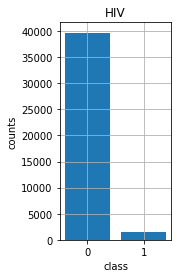

In [27]:
keys = ['0', '1']
bottom = df.groupby('HIV_active').count()['smiles'].values
plt.figure(figsize=(2,4))
plt.bar(keys, bottom)
plt.xlabel('class')
plt.ylabel('counts')
plt.title('HIV')
plt.grid()
plt.show()

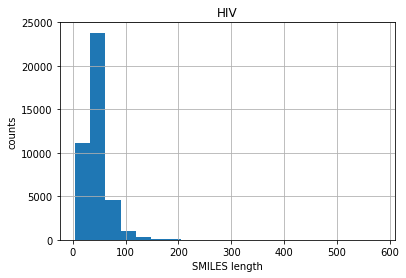

In [29]:
plt.hist(list(map(len, df['smiles'].values)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('HIV')
plt.grid()
plt.show()

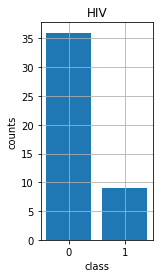

In [5]:
df_large = df[np.array(list(map(len, df['smiles'])))>218]

keys = ['0', '1']
bottom = df_large.groupby('HIV_active').count()['smiles'].values
plt.figure(figsize=(2,4))
plt.bar(keys, bottom)
plt.xlabel('class')
plt.ylabel('counts')
plt.title('HIV')
plt.grid()
plt.show()

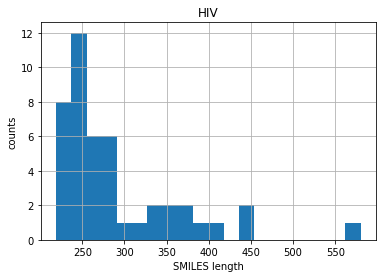

In [6]:
plt.hist(list(map(len, df_large['smiles'].values)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('HIV')
plt.grid()
plt.show()

In [7]:
df_train = df[np.array(list(map(len, df['smiles'])))<=218]
df_test = df[np.array(list(map(len, df['smiles'])))>218]

In [9]:
def evaluate_long_smiles(X_train, X_test, y_train, y_test, n_repeats):
    auc = np.empty(n_repeats)
    for i in range(n_repeats):
        clf = MLPClassifier(max_iter=1000)
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
        auc[i] = roc_auc_score(y_test, y_score[:,1])
    ret = {}
    ret['auc mean'] = np.mean(auc)
    ret['auc std'] = np.mean(np.std(auc, axis=0))
    return ret

### ST

In [62]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

SMILES is too long (220)
SMILES is too long (274)
SMILES is too long (247)
SMILES is too long (226)
SMILES is too long (244)
SMILES is too long (243)
SMILES is too long (253)
SMILES is too long (266)
SMILES is too long (346)
SMILES is too long (232)
SMILES is too long (242)
SMILES is too long (247)
SMILES is too long (240)
SMILES is too long (370)
SMILES is too long (224)
SMILES is too long (283)
SMILES is too long (265)
SMILES is too long (240)
SMILES is too long (219)
SMILES is too long (246)
SMILES is too long (243)
SMILES is too long (284)
SMILES is too long (270)
SMILES is too long (232)
SMILES is too long (260)
SMILES is too long (284)
SMILES is too long (284)
SMILES is too long (439)
SMILES is too long (491)
SMILES is too long (439)
SMILES is too long (296)
SMILES is too long (341)
SMILES is too long (285)
SMILES is too long (327)
SMILES is too long (341)
SMILES is too long (400)
SMILES is too long (263)
SMILES is too long (238)
SMILES is too long (383)
SMILES is too long (360)


KeyboardInterrupt: 

In [ ]:
for rate in rates:
    score_dic = evaluate_mlp_classification(X, df['HIV_active'].values, rate, 20)
    print(rate, score_dic)

In [8]:
x_split = [split(sm) for sm in df_train['smiles'].values]
xid, _ = get_array(x_split)
X_train = trfm.encode(torch.t(xid))
print(X_train.shape)
x_split = [split(sm) for sm in df_test['smiles'].values]
xid, _ = get_array(x_split)
X_test = trfm.encode(torch.t(xid))
print(X_test.shape)
y_train, y_test = df_train['HIV_active'].values, df_test['HIV_active'].values

There are 41082 molecules. It will take a little time.
(41082, 1024)
SMILES is too long (220)
SMILES is too long (274)
SMILES is too long (247)
SMILES is too long (226)
SMILES is too long (244)
SMILES is too long (243)
SMILES is too long (253)
SMILES is too long (266)
SMILES is too long (346)
SMILES is too long (232)
SMILES is too long (242)
SMILES is too long (247)
SMILES is too long (240)
SMILES is too long (370)
SMILES is too long (224)
SMILES is too long (283)
SMILES is too long (265)
SMILES is too long (240)
SMILES is too long (219)
SMILES is too long (246)
SMILES is too long (243)
SMILES is too long (284)
SMILES is too long (270)
SMILES is too long (232)
SMILES is too long (260)
SMILES is too long (284)
SMILES is too long (284)
SMILES is too long (439)
SMILES is too long (491)
SMILES is too long (439)
SMILES is too long (296)
SMILES is too long (341)
SMILES is too long (285)
SMILES is too long (327)
SMILES is too long (341)
SMILES is too long (400)
SMILES is too long (263)
SMILES

In [10]:
score_dic = evaluate_long_smiles(X_train, X_test, y_train, y_test, 20)
print(score_dic)

{'auc mean': 0.7277006172839505, 'auc std': 0.08278493969947416}


### ECFP4

In [19]:
x,X,y = extract_morgan(df['smiles'].values, df['HIV_active'].values)
print(len(X), len(y))

41127 41127


In [20]:
for rate in rates:
    score_dic = evaluate_mlp_classification(X, y, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.563763476646091, 'auc std': 0.04793740061789739}
0.025 {'auc mean': 0.6084993676666952, 'auc std': 0.03095860948054148}
0.05 {'auc mean': 0.663516786233209, 'auc std': 0.014285121222973821}
0.1 {'auc mean': 0.7017281389123037, 'auc std': 0.009831246617193107}
0.2 {'auc mean': 0.7457630855006574, 'auc std': 0.006481691881209791}
0.4 {'auc mean': 0.77975386640347, 'auc std': 0.006372212100030508}
0.8 {'auc mean': 0.8160612792871895, 'auc std': 0.016513397859882258}


In [11]:
x,X_train,y_train = extract_morgan(df_train['smiles'].values, df_train['HIV_active'].values)
print(len(X_train), len(y_train))
x,X_test,y_test = extract_morgan(df_test['smiles'].values, df_test['HIV_active'].values)
print(len(X_test), len(y_test))

41082 41082
45 45


In [12]:
score_dic = evaluate_long_smiles(X_train, X_test, y_train, y_test, 20)
print(score_dic)

{'auc mean': 0.8662037037037035, 'auc std': 0.02887534965521136}


### RNN Seq2seq

In [14]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = rnn.encode(torch.t(xid))
print(X.shape)

SMILES is too long (220)
SMILES is too long (274)
SMILES is too long (247)
SMILES is too long (226)
SMILES is too long (244)
SMILES is too long (243)
SMILES is too long (253)
SMILES is too long (266)
SMILES is too long (346)
SMILES is too long (232)
SMILES is too long (242)
SMILES is too long (247)
SMILES is too long (240)
SMILES is too long (370)
SMILES is too long (224)
SMILES is too long (283)
SMILES is too long (265)
SMILES is too long (240)
SMILES is too long (219)
SMILES is too long (246)
SMILES is too long (243)
SMILES is too long (284)
SMILES is too long (270)
SMILES is too long (232)
SMILES is too long (260)
SMILES is too long (284)
SMILES is too long (284)
SMILES is too long (439)
SMILES is too long (491)
SMILES is too long (439)
SMILES is too long (296)
SMILES is too long (341)
SMILES is too long (285)
SMILES is too long (327)
SMILES is too long (341)
SMILES is too long (400)
SMILES is too long (263)
SMILES is too long (238)
SMILES is too long (383)
SMILES is too long (360)


In [15]:
for rate in rates:
    score_dic = evaluate_mlp_classification(X, df['HIV_active'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.6098477756348614, 'auc std': 0.02716138712537457}
0.025 {'auc mean': 0.634419126161075, 'auc std': 0.018587064399343493}
0.05 {'auc mean': 0.6558364753408517, 'auc std': 0.01908470161513702}
0.1 {'auc mean': 0.6814602507239775, 'auc std': 0.013703095589888711}
0.2 {'auc mean': 0.7022542175175434, 'auc std': 0.00944552220627052}
0.4 {'auc mean': 0.7286772527262663, 'auc std': 0.010733282123696383}
0.8 {'auc mean': 0.7588300143038191, 'auc std': 0.014668057074799323}


In [13]:
x_split = [split(sm) for sm in df_train['smiles'].values]
xid, _ = get_array(x_split)
X_train = rnn.encode(torch.t(xid))
print(X_train.shape)
x_split = [split(sm) for sm in df_test['smiles'].values]
xid, _ = get_array(x_split)
X_test = rnn.encode(torch.t(xid))
print(X_test.shape)
y_train, y_test = df_train['HIV_active'].values, df_test['HIV_active'].values

There are 41082 molecules. It will take a little time.
(41082, 1024)
SMILES is too long (220)
SMILES is too long (274)
SMILES is too long (247)
SMILES is too long (226)
SMILES is too long (244)
SMILES is too long (243)
SMILES is too long (253)
SMILES is too long (266)
SMILES is too long (346)
SMILES is too long (232)
SMILES is too long (242)
SMILES is too long (247)
SMILES is too long (240)
SMILES is too long (370)
SMILES is too long (224)
SMILES is too long (283)
SMILES is too long (265)
SMILES is too long (240)
SMILES is too long (219)
SMILES is too long (246)
SMILES is too long (243)
SMILES is too long (284)
SMILES is too long (270)
SMILES is too long (232)
SMILES is too long (260)
SMILES is too long (284)
SMILES is too long (284)
SMILES is too long (439)
SMILES is too long (491)
SMILES is too long (439)
SMILES is too long (296)
SMILES is too long (341)
SMILES is too long (285)
SMILES is too long (327)
SMILES is too long (341)
SMILES is too long (400)
SMILES is too long (263)
SMILES

In [14]:
score_dic = evaluate_long_smiles(X_train, X_test, y_train, y_test, 20)
print(score_dic)

{'auc mean': 0.659567901234568, 'auc std': 0.06777555709330638}


### GraphConv

In [8]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks=['HIV_active'],
      smiles_field='smiles',
      featurizer=featurizer)
dataset = loader.featurize('data/hiv.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/hiv.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 34.119 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 1 took 35.415 s
Loading shard 3 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 2 took 36.701 s
Loading shard 4 of size 8192.
Featurizing sample 0
Featuri

In [32]:
for rate in rates:
    score_dic = evaluate_classification_single_dc(dataset, rate, 20)
    print(rate, score_dic)

TIMING: dataset construction took 0.324 s
Loading dataset from disk.
TIMING: dataset construction took 43.923 s
Loading dataset from disk.
TIMING: dataset construction took 44.615 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.6144364912993722]
TIMING: dataset construction took 0.535 s
Loading dataset from disk.
TIMING: dataset construction took 44.743 s
Loading dataset from disk.
TIMING: dataset construction took 42.145 s
Loading dataset from disk.
computed_metrics: [0.5026506014385087]
TIMING: dataset construction took 0.428 s
Loading dataset from disk.
TIMING: dataset construction took 42.678 s
Loading dataset from disk.
TIMING: dataset construction took 42.854 s
Loading dataset from disk.
computed_metrics: [0.666043081620195]
TIMING: dataset construction took 0.503 s
Loading dataset from disk.
TIMING: dataset construction took 41.925 s
Loading dataset from disk.
TIMING: dataset construction took 44.111 s
Loading dataset from disk.
computed_metrics: [0.5827571820203425]
TIMING: dataset construction took 0.457 s
Loading dataset from disk.
TIMING: dataset construction took 42.678 s
Loading dataset from disk.
TIMING: dataset construction took 43.625 s
Loading dataset from disk.
computed_

computed_metrics: [0.7056943971013692]
TIMING: dataset construction took 1.130 s
Loading dataset from disk.
TIMING: dataset construction took 41.673 s
Loading dataset from disk.
TIMING: dataset construction took 41.278 s
Loading dataset from disk.
computed_metrics: [0.691252627194979]
TIMING: dataset construction took 0.764 s
Loading dataset from disk.
TIMING: dataset construction took 41.600 s
Loading dataset from disk.
TIMING: dataset construction took 41.334 s
Loading dataset from disk.
computed_metrics: [0.6789035764499585]
TIMING: dataset construction took 1.133 s
Loading dataset from disk.
TIMING: dataset construction took 41.583 s
Loading dataset from disk.
TIMING: dataset construction took 41.320 s
Loading dataset from disk.
computed_metrics: [0.6999079152413961]
TIMING: dataset construction took 1.055 s
Loading dataset from disk.
TIMING: dataset construction took 40.991 s
Loading dataset from disk.
TIMING: dataset construction took 42.545 s
Loading dataset from disk.
computed_

TIMING: dataset construction took 38.928 s
Loading dataset from disk.
computed_metrics: [0.7381032488999822]
TIMING: dataset construction took 3.879 s
Loading dataset from disk.
TIMING: dataset construction took 38.222 s
Loading dataset from disk.
TIMING: dataset construction took 37.999 s
Loading dataset from disk.
computed_metrics: [0.7235555302038013]
TIMING: dataset construction took 4.769 s
Loading dataset from disk.
TIMING: dataset construction took 37.124 s
Loading dataset from disk.
TIMING: dataset construction took 37.132 s
Loading dataset from disk.
computed_metrics: [0.7314114524086919]
TIMING: dataset construction took 3.739 s
Loading dataset from disk.
TIMING: dataset construction took 38.186 s
Loading dataset from disk.
TIMING: dataset construction took 38.153 s
Loading dataset from disk.
computed_metrics: [0.7203373912339345]
TIMING: dataset construction took 3.908 s
Loading dataset from disk.
TIMING: dataset construction took 38.075 s
Loading dataset from disk.
TIMING: 

TIMING: dataset construction took 34.773 s
Loading dataset from disk.
computed_metrics: [0.7336790978356589]
0.2 {'auc std': 0.013525661229518935, 'auc mean': 0.7444346641952958}
TIMING: dataset construction took 17.069 s
Loading dataset from disk.
TIMING: dataset construction took 26.452 s
Loading dataset from disk.
TIMING: dataset construction took 26.382 s
Loading dataset from disk.
computed_metrics: [0.7665286123942283]
TIMING: dataset construction took 15.247 s
Loading dataset from disk.
TIMING: dataset construction took 26.813 s
Loading dataset from disk.
TIMING: dataset construction took 27.029 s
Loading dataset from disk.
computed_metrics: [0.7736195207891015]
TIMING: dataset construction took 16.099 s
Loading dataset from disk.
TIMING: dataset construction took 26.008 s
Loading dataset from disk.
TIMING: dataset construction took 26.100 s
Loading dataset from disk.
computed_metrics: [0.7502174312676655]
TIMING: dataset construction took 17.069 s
Loading dataset from disk.
TIMI

TIMING: dataset construction took 8.706 s
Loading dataset from disk.
TIMING: dataset construction took 8.545 s
Loading dataset from disk.
computed_metrics: [0.7779626663327689]
TIMING: dataset construction took 35.090 s
Loading dataset from disk.
TIMING: dataset construction took 7.643 s
Loading dataset from disk.
TIMING: dataset construction took 7.402 s
Loading dataset from disk.
computed_metrics: [0.7777825460811738]
TIMING: dataset construction took 35.311 s
Loading dataset from disk.
TIMING: dataset construction took 7.974 s
Loading dataset from disk.
TIMING: dataset construction took 7.753 s
Loading dataset from disk.
computed_metrics: [0.7925340082989097]
TIMING: dataset construction took 34.544 s
Loading dataset from disk.
TIMING: dataset construction took 8.344 s
Loading dataset from disk.
TIMING: dataset construction took 8.056 s
Loading dataset from disk.
computed_metrics: [0.8062909482205113]
TIMING: dataset construction took 35.021 s
Loading dataset from disk.
TIMING: data

In [32]:
# long sequence
n_repeats = 20
aucs = np.empty(n_repeats)
for i in range(n_repeats):
    clf = GraphConvModel(n_tasks=1, batch_size=64, mode='classification')
    train = dataset.select(np.where(np.array(list(map(len, df['smiles'])))<=218)[0])
    val = dataset.select(np.where(np.array(list(map(len, df['smiles'])))>218)[0])
    clf.fit(train)
    metrics = [dc.metrics.Metric(dc.metrics.roc_auc_score)]
    scores = clf.evaluate(val, metrics)
    aucs[i] = scores['roc_auc_score']
ret = {}
ret['auc mean'] = np.mean(aucs)
ret['auc std'] = np.std(aucs)
print(ret)

TIMING: dataset construction took 62.585 s
Loading dataset from disk.
TIMING: dataset construction took 21.625 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.6728395061728396]
TIMING: dataset construction took 61.597 s
Loading dataset from disk.
TIMING: dataset construction took 19.952 s
Loading dataset from disk.
computed_metrics: [0.5617283950617284]
TIMING: dataset construction took 61.937 s
Loading dataset from disk.
TIMING: dataset construction took 19.794 s
Loading dataset from disk.
computed_metrics: [0.6111111111111112]
TIMING: dataset construction took 64.492 s
Loading dataset from disk.
TIMING: dataset construction took 20.993 s
Loading dataset from disk.
computed_metrics: [0.7253086419753086]
TIMING: dataset construction took 62.346 s
Loading dataset from disk.
TIMING: dataset construction took 20.362 s
Loading dataset from disk.
computed_metrics: [0.7685185185185185]
TIMING: dataset construction took 62.144 s
Loading dataset from disk.
TIMING: dataset construction took 19.900 s
Loading dataset from disk.
computed_metrics: [0.5895061728395061]
TIMING: dataset construction took 62.992 s
Loading dataset from di

### Bert

In [16]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, x_seg = get_array(x_split)
X = bert.encode(xid, x_seg)
print(X.shape)

SMILES is too long (220)
SMILES is too long (274)
SMILES is too long (247)
SMILES is too long (226)
SMILES is too long (244)
SMILES is too long (243)
SMILES is too long (253)
SMILES is too long (266)
SMILES is too long (346)
SMILES is too long (232)
SMILES is too long (242)
SMILES is too long (247)
SMILES is too long (240)
SMILES is too long (370)
SMILES is too long (224)
SMILES is too long (283)
SMILES is too long (265)
SMILES is too long (240)
SMILES is too long (219)
SMILES is too long (246)
SMILES is too long (243)
SMILES is too long (284)
SMILES is too long (270)
SMILES is too long (232)
SMILES is too long (260)
SMILES is too long (284)
SMILES is too long (284)
SMILES is too long (439)
SMILES is too long (491)
SMILES is too long (439)
SMILES is too long (296)
SMILES is too long (341)
SMILES is too long (285)
SMILES is too long (327)
SMILES is too long (341)
SMILES is too long (400)
SMILES is too long (263)
SMILES is too long (238)
SMILES is too long (383)
SMILES is too long (360)


In [17]:
for rate in rates:
    score_dic = evaluate_mlp_classification(X, df['HIV_active'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.6358831968791019, 'auc std': 0.026160360279364376}
0.025 {'auc mean': 0.6600626232052511, 'auc std': 0.01198939527851428}
0.05 {'auc mean': 0.6701859670863104, 'auc std': 0.008699714680064388}
0.1 {'auc mean': 0.683390765064678, 'auc std': 0.008329895622390684}
0.2 {'auc mean': 0.6905485735642622, 'auc std': 0.006784560106001557}
0.4 {'auc mean': 0.7009763279203247, 'auc std': 0.010631553956085959}
0.8 {'auc mean': 0.715550117207612, 'auc std': 0.014715120476847152}


## BACE

In [57]:
df = pd.read_csv('data/bace.csv')
print(df.shape)
df.head()

(1513, 595)


,mol,CID,Class,Model,pIC50,MW,AlogP,HBA,HBD,RB,...,PEOE6 (PEOE6),PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14),canvasUID
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901,431.56979,4.4014,3,2,5,...,53.205711,78.640335,226.85541,107.43491,37.133846,0.000000,7.980170,0.0,0.000000,1
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872,657.81073,2.6412,5,4,16,...,73.817162,47.171600,365.67694,174.07675,34.923889,7.980170,24.148668,0.0,24.663788,2
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970,591.74091,2.5499,4,3,11,...,70.365707,47.941147,192.40652,255.75255,23.654478,0.230159,15.879790,0.0,24.663788,3
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970,591.67828,3.1680,4,3,12,...,56.657166,37.954151,194.35304,202.76335,36.498634,0.980913,8.188327,0.0,26.385181,4
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970,629.71283,3.5086,3,3,11,...,78.945702,39.361153,179.71288,220.46130,23.654478,0.230159,15.879790,0.0,26.100143,5


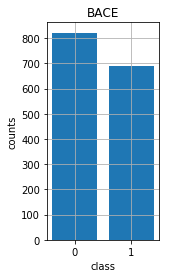

In [49]:
keys = ['0', '1']
bottom = df.groupby('Class').count()['CID'].values
plt.figure(figsize=(2,4))
plt.bar(keys, bottom)
plt.xlabel('class')
plt.ylabel('counts')
plt.title('BACE')
plt.grid()
plt.show()

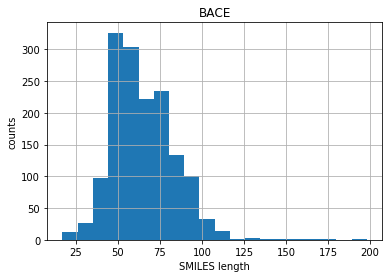

In [50]:
plt.hist(list(map(len, df['mol'].values)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('BACE')
plt.grid()
plt.show()

### ST

In [52]:
x_split = [split(sm) for sm in df['mol'].values]
xid, _ = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

There are 1513 molecules. It will take a little time.
(1513, 1024)


In [53]:
for rate in rates:
    score_dic = evaluate_mlp_classification(X, df['Class'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.5916079452430238, 'auc std': 0.0525840624540231}
0.025 {'auc mean': 0.6224383403509031, 'auc std': 0.031943157030004464}
0.05 {'auc mean': 0.6839151694447854, 'auc std': 0.0343080646046333}
0.1 {'auc mean': 0.7265169027548448, 'auc std': 0.025865711293704522}
0.2 {'auc mean': 0.7753986269972573, 'auc std': 0.016742446037013418}
0.4 {'auc mean': 0.7807202033285271, 'auc std': 0.02344691441296362}
0.8 {'auc mean': 0.849997804128239, 'auc std': 0.012312074771296606}


### ECFP4

In [54]:
x,X,y = extract_morgan(df['mol'].values, df['Class'].values)
print(len(X), len(y))

1513 1513


In [55]:
for rate in rates:
    score_dic = evaluate_mlp_classification(X, df['Class'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.6299620354275904, 'auc std': 0.050064850038022114}
0.025 {'auc mean': 0.6969026339936509, 'auc std': 0.04028410459645388}
0.05 {'auc mean': 0.7364717501076752, 'auc std': 0.02530942379913975}
0.1 {'auc mean': 0.7847283175458417, 'auc std': 0.018398889354123107}
0.2 {'auc mean': 0.821187072997796, 'auc std': 0.01676016416578495}
0.4 {'auc mean': 0.8488946455191962, 'auc std': 0.008248150865819617}
0.8 {'auc mean': 0.8682454984628898, 'auc std': 0.015548778463387536}


### RNN-Seq2seq

In [58]:
x_split = [split(sm) for sm in df['mol'].values]
xid, _ = get_array(x_split)
X = rnn.encode(torch.t(xid))
print(X.shape)

There are 1513 molecules. It will take a little time.
(1513, 1024)


In [59]:
for rate in rates:
    score_dic = evaluate_mlp_classification(X, df['Class'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.582567400413995, 'auc std': 0.04280790016755629}
0.025 {'auc mean': 0.6344276548983624, 'auc std': 0.03381583945295958}
0.05 {'auc mean': 0.6776480802623963, 'auc std': 0.033850761210358356}
0.1 {'auc mean': 0.7395557052229077, 'auc std': 0.016619885405124386}
0.2 {'auc mean': 0.7896572714730923, 'auc std': 0.013972109845764507}
0.4 {'auc mean': 0.7692541362203378, 'auc std': 0.012970396846871084}
0.8 {'auc mean': 0.8291567852437417, 'auc std': 0.020508129855815155}


### GraphConv

In [9]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks=['Class'],
      smiles_field='mol',
      featurizer=featurizer)
dataset = loader.featurize('data/bace.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/bace.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 8.031 s
TIMING: dataset construction took 10.188 s
Loading dataset from disk.


In [10]:
for rate in rates:
    score_dic = evaluate_classification_single_dc(dataset, rate, 20)
    print(rate, score_dic)

TIMING: dataset construction took 0.027 s
Loading dataset from disk.
TIMING: dataset construction took 1.781 s
Loading dataset from disk.
TIMING: dataset construction took 1.739 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.5835619904922004]
TIMING: dataset construction took 0.020 s
Loading dataset from disk.
TIMING: dataset construction took 1.783 s
Loading dataset from disk.
TIMING: dataset construction took 1.871 s
Loading dataset from disk.
computed_metrics: [0.6029860333591709]
TIMING: dataset construction took 0.031 s
Loading dataset from disk.
TIMING: dataset construction took 1.773 s
Loading dataset from disk.
TIMING: dataset construction took 1.835 s
Loading dataset from disk.
computed_metrics: [0.6645591809597855]
TIMING: dataset construction took 0.027 s
Loading dataset from disk.
TIMING: dataset construction took 1.854 s
Loading dataset from disk.
TIMING: dataset construction took 1.765 s
Loading dataset from disk.
computed_metrics: [0.5958381644806285]
TIMING: dataset construction took 0.020 s
Loading dataset from disk.
TIMING: dataset construction took 1.790 s
Loading dataset from disk.
TIMING: dataset construction took 1.778 s
Loading dataset from disk.
computed_metrics

TIMING: dataset construction took 0.042 s
Loading dataset from disk.
TIMING: dataset construction took 1.751 s
Loading dataset from disk.
TIMING: dataset construction took 1.757 s
Loading dataset from disk.
computed_metrics: [0.6119759779966834]
TIMING: dataset construction took 0.037 s
Loading dataset from disk.
TIMING: dataset construction took 1.773 s
Loading dataset from disk.
TIMING: dataset construction took 1.771 s
Loading dataset from disk.
computed_metrics: [0.6590925742755613]
TIMING: dataset construction took 0.043 s
Loading dataset from disk.
TIMING: dataset construction took 1.784 s
Loading dataset from disk.
TIMING: dataset construction took 1.779 s
Loading dataset from disk.
computed_metrics: [0.5270061927493227]
TIMING: dataset construction took 0.041 s
Loading dataset from disk.
TIMING: dataset construction took 1.768 s
Loading dataset from disk.
TIMING: dataset construction took 1.764 s
Loading dataset from disk.
computed_metrics: [0.6207750195609489]
TIMING: dataset 

computed_metrics: [0.7810650150371379]
TIMING: dataset construction took 0.177 s
Loading dataset from disk.
TIMING: dataset construction took 1.627 s
Loading dataset from disk.
TIMING: dataset construction took 1.570 s
Loading dataset from disk.
computed_metrics: [0.7852157748497135]
TIMING: dataset construction took 0.171 s
Loading dataset from disk.
TIMING: dataset construction took 1.635 s
Loading dataset from disk.
TIMING: dataset construction took 1.627 s
Loading dataset from disk.
computed_metrics: [0.7641650271708513]
TIMING: dataset construction took 0.168 s
Loading dataset from disk.
TIMING: dataset construction took 1.625 s
Loading dataset from disk.
TIMING: dataset construction took 1.627 s
Loading dataset from disk.
computed_metrics: [0.7740329895747231]
TIMING: dataset construction took 0.151 s
Loading dataset from disk.
TIMING: dataset construction took 1.646 s
Loading dataset from disk.
TIMING: dataset construction took 1.636 s
Loading dataset from disk.
computed_metrics

TIMING: dataset construction took 0.831 s
Loading dataset from disk.
TIMING: dataset construction took 1.056 s
Loading dataset from disk.
TIMING: dataset construction took 1.064 s
Loading dataset from disk.
computed_metrics: [0.839820700123328]
TIMING: dataset construction took 0.714 s
Loading dataset from disk.
TIMING: dataset construction took 1.029 s
Loading dataset from disk.
TIMING: dataset construction took 1.030 s
Loading dataset from disk.
computed_metrics: [0.8180194682697386]
TIMING: dataset construction took 0.738 s
Loading dataset from disk.
TIMING: dataset construction took 0.999 s
Loading dataset from disk.
TIMING: dataset construction took 1.015 s
Loading dataset from disk.
computed_metrics: [0.8438512671375156]
TIMING: dataset construction took 0.698 s
Loading dataset from disk.
TIMING: dataset construction took 1.027 s
Loading dataset from disk.
TIMING: dataset construction took 1.040 s
Loading dataset from disk.
computed_metrics: [0.8408126332490455]
TIMING: dataset c

TIMING: dataset construction took 0.391 s
Loading dataset from disk.
TIMING: dataset construction took 0.344 s
Loading dataset from disk.
computed_metrics: [0.8502087219113598]
TIMING: dataset construction took 1.456 s
Loading dataset from disk.
TIMING: dataset construction took 0.356 s
Loading dataset from disk.
TIMING: dataset construction took 0.368 s
Loading dataset from disk.
computed_metrics: [0.8413244559631798]
TIMING: dataset construction took 1.448 s
Loading dataset from disk.
TIMING: dataset construction took 0.341 s
Loading dataset from disk.
TIMING: dataset construction took 0.351 s
Loading dataset from disk.
computed_metrics: [0.8511774431386567]
TIMING: dataset construction took 1.446 s
Loading dataset from disk.
TIMING: dataset construction took 0.356 s
Loading dataset from disk.
TIMING: dataset construction took 0.374 s
Loading dataset from disk.
computed_metrics: [0.884649335746127]
TIMING: dataset construction took 1.436 s
Loading dataset from disk.
TIMING: dataset c

### BERT

In [60]:
x_split = [split(sm) for sm in df['mol'].values]
xid, xseg = get_array(x_split)
X = bert.encode(xid, xseg)

There are 1513 molecules. It will take a little time.


In [61]:
for rate in rates:
    score_dic = evaluate_mlp_classification(X, df['Class'].values, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.576825472956891, 'auc std': 0.051589652074179204}
0.025 {'auc mean': 0.603195923396257, 'auc std': 0.0584623250755939}


/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.05 {'auc mean': 0.6607868186008259, 'auc std': 0.04092274370568475}
0.1 {'auc mean': 0.6960517511080212, 'auc std': 0.06755893752884638}
0.2 {'auc mean': 0.7220647806658348, 'auc std': 0.018398236241281854}
0.4 {'auc mean': 0.6963501063075833, 'auc std': 0.02542892283824217}
0.8 {'auc mean': 0.7378787878787879, 'auc std': 0.029773901243748728}


## BBBP

In [6]:
df = pd.read_csv('data/bbbp.csv')
print(df.shape)
df.head()

(2050, 4)


,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


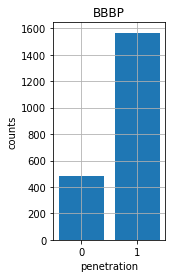

In [24]:
keys = ['0', '1']
bottom = df.groupby('p_np').count()['num'].values
plt.figure(figsize=(2,4))
plt.bar(keys, bottom)
plt.xlabel('penetration')
plt.ylabel('counts')
plt.title('BBBP')
plt.grid()
plt.show()

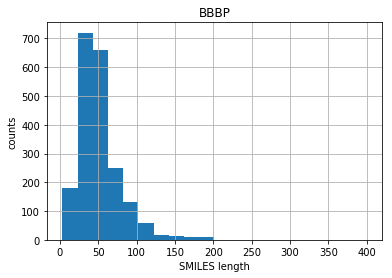

In [25]:
plt.hist(list(map(len, df['smiles'].values)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('BBBP')
plt.grid()
plt.show()

### ST

In [7]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

SMILES is too long (256)
SMILES is too long (239)
SMILES is too long (258)
SMILES is too long (380)
SMILES is too long (332)
There are 2050 molecules. It will take a little time.
(2050, 1024)


In [10]:
for rate in rates:
    score_dic = evaluate_mlp_classification(X, df['p_np'], rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.8347635956857836, 'auc std': 0.03655667894587934}
0.025 {'auc mean': 0.8665631495870432, 'auc std': 0.019857283458358032}
0.05 {'auc mean': 0.8853260145935845, 'auc std': 0.02346809873291377}
0.1 {'auc mean': 0.9104212113801256, 'auc std': 0.009691814726953234}
0.2 {'auc mean': 0.9260329639454264, 'auc std': 0.009046904166355963}
0.4 {'auc mean': 0.9327153338224505, 'auc std': 0.00640613201510519}
0.8 {'auc mean': 0.9410526662494647, 'auc std': 0.008820456842932357}


### ECFP4

In [14]:
x,X,y = extract_morgan(df['smiles'].values, df['p_np'].values)
print(len(X), len(y))

2039 2039


In [16]:
for rate in rates:
    score_dic = evaluate_mlp_classification(X, y, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.6233275665975664, 'auc std': 0.07152790559665126}
0.025 {'auc mean': 0.6620199951039291, 'auc std': 0.05188082443039691}
0.05 {'auc mean': 0.7322774966099309, 'auc std': 0.030639432892693365}
0.1 {'auc mean': 0.764260100238624, 'auc std': 0.022598618056672664}
0.2 {'auc mean': 0.8093911682871102, 'auc std': 0.018374052902075565}
0.4 {'auc mean': 0.8510450053418804, 'auc std': 0.00943495257087519}
0.8 {'auc mean': 0.8779755942841879, 'auc std': 0.01720593557596936}


### RNN Seq2seq

In [18]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = rnn.encode(torch.t(xid))
print(X.shape)

SMILES is too long (256)
SMILES is too long (239)
SMILES is too long (258)
SMILES is too long (380)
SMILES is too long (332)
There are 2050 molecules. It will take a little time.
(2050, 1024)


In [20]:
for rate in rates:
    score_dic = evaluate_mlp_classification(X, df['p_np'], rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.7911813579705199, 'auc std': 0.041783380559957825}
0.025 {'auc mean': 0.841184513289092, 'auc std': 0.019145977936395886}
0.05 {'auc mean': 0.8578805942196294, 'auc std': 0.020174458806343432}
0.1 {'auc mean': 0.8976094399608705, 'auc std': 0.010577078969817744}
0.2 {'auc mean': 0.9159243787754834, 'auc std': 0.008341542609256257}
0.4 {'auc mean': 0.9348222670579605, 'auc std': 0.006084300148200208}
0.8 {'auc mean': 0.951493692566121, 'auc std': 0.00789456539422481}


### GraphConv

In [7]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks=['p_np'],
      smiles_field='smiles',
      featurizer=featurizer)
dataset = loader.featurize('data/bbbp.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/bbbp.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
TIMING: featurizing shard 0 took 8.601 s
TIMING: dataset construction took 10.527 s
Loading dataset from disk.


In [8]:
for rate in rates:
    score_dic = evaluate_classification_single_dc(dataset, rate, 20)
    print(rate, score_dic)

TIMING: dataset construction took 0.029 s
Loading dataset from disk.
TIMING: dataset construction took 1.838 s
Loading dataset from disk.
TIMING: dataset construction took 1.862 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.7597866386703978]
TIMING: dataset construction took 0.026 s
Loading dataset from disk.
TIMING: dataset construction took 1.934 s
Loading dataset from disk.
TIMING: dataset construction took 1.887 s
Loading dataset from disk.
computed_metrics: [0.5681457527852153]
TIMING: dataset construction took 0.025 s
Loading dataset from disk.
TIMING: dataset construction took 1.918 s
Loading dataset from disk.
TIMING: dataset construction took 1.877 s
Loading dataset from disk.
computed_metrics: [0.672849671990795]
TIMING: dataset construction took 0.035 s
Loading dataset from disk.
TIMING: dataset construction took 1.923 s
Loading dataset from disk.
TIMING: dataset construction took 1.863 s
Loading dataset from disk.
computed_metrics: [0.7085630177017342]
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 1.959 s
Loading dataset from disk.
TIMING: dataset construction took 1.880 s
Loading dataset from disk.
computed_metrics:

TIMING: dataset construction took 0.056 s
Loading dataset from disk.
TIMING: dataset construction took 1.913 s
Loading dataset from disk.
TIMING: dataset construction took 1.806 s
Loading dataset from disk.
computed_metrics: [0.6934550422786699]
TIMING: dataset construction took 0.050 s
Loading dataset from disk.
TIMING: dataset construction took 1.818 s
Loading dataset from disk.
TIMING: dataset construction took 1.818 s
Loading dataset from disk.
computed_metrics: [0.7206584419991963]
TIMING: dataset construction took 0.052 s
Loading dataset from disk.
TIMING: dataset construction took 1.825 s
Loading dataset from disk.
TIMING: dataset construction took 1.816 s
Loading dataset from disk.
computed_metrics: [0.7594180751093882]
TIMING: dataset construction took 0.048 s
Loading dataset from disk.
TIMING: dataset construction took 1.868 s
Loading dataset from disk.
TIMING: dataset construction took 1.840 s
Loading dataset from disk.
computed_metrics: [0.6924991009063988]
TIMING: dataset 

computed_metrics: [0.7904611906959325]
TIMING: dataset construction took 0.208 s
Loading dataset from disk.
TIMING: dataset construction took 1.822 s
Loading dataset from disk.
TIMING: dataset construction took 1.665 s
Loading dataset from disk.
computed_metrics: [0.8217546721645083]
TIMING: dataset construction took 0.182 s
Loading dataset from disk.
TIMING: dataset construction took 1.714 s
Loading dataset from disk.
TIMING: dataset construction took 1.666 s
Loading dataset from disk.
computed_metrics: [0.8238422643664579]
TIMING: dataset construction took 0.174 s
Loading dataset from disk.
TIMING: dataset construction took 1.697 s
Loading dataset from disk.
TIMING: dataset construction took 1.713 s
Loading dataset from disk.
computed_metrics: [0.8207562939705797]
TIMING: dataset construction took 0.182 s
Loading dataset from disk.
TIMING: dataset construction took 1.699 s
Loading dataset from disk.
TIMING: dataset construction took 1.707 s
Loading dataset from disk.
computed_metrics

TIMING: dataset construction took 0.787 s
Loading dataset from disk.
TIMING: dataset construction took 1.106 s
Loading dataset from disk.
TIMING: dataset construction took 1.143 s
Loading dataset from disk.
computed_metrics: [0.8910557361261586]
TIMING: dataset construction took 0.746 s
Loading dataset from disk.
TIMING: dataset construction took 1.109 s
Loading dataset from disk.
TIMING: dataset construction took 1.095 s
Loading dataset from disk.
computed_metrics: [0.8973925848925849]
TIMING: dataset construction took 0.730 s
Loading dataset from disk.
TIMING: dataset construction took 1.095 s
Loading dataset from disk.
TIMING: dataset construction took 1.083 s
Loading dataset from disk.
computed_metrics: [0.877558683265205]
TIMING: dataset construction took 0.715 s
Loading dataset from disk.
TIMING: dataset construction took 1.081 s
Loading dataset from disk.
TIMING: dataset construction took 1.070 s
Loading dataset from disk.
computed_metrics: [0.8901678767270165]
TIMING: dataset c

TIMING: dataset construction took 0.374 s
Loading dataset from disk.
TIMING: dataset construction took 0.371 s
Loading dataset from disk.
computed_metrics: [0.9036324786324788]
TIMING: dataset construction took 1.526 s
Loading dataset from disk.
TIMING: dataset construction took 0.372 s
Loading dataset from disk.
TIMING: dataset construction took 0.347 s
Loading dataset from disk.
computed_metrics: [0.9109445701357467]
TIMING: dataset construction took 1.503 s
Loading dataset from disk.
TIMING: dataset construction took 0.382 s
Loading dataset from disk.
TIMING: dataset construction took 0.357 s
Loading dataset from disk.
computed_metrics: [0.9113629426129426]
TIMING: dataset construction took 1.507 s
Loading dataset from disk.
TIMING: dataset construction took 0.387 s
Loading dataset from disk.
TIMING: dataset construction took 0.367 s
Loading dataset from disk.
computed_metrics: [0.9288817663817663]
TIMING: dataset construction took 1.499 s
Loading dataset from disk.
TIMING: dataset 

### BERT

In [26]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, x_seg = get_array(x_split)
X = bert.encode(xid, x_seg)
print(X.shape)

SMILES is too long (256)
SMILES is too long (239)
SMILES is too long (258)
SMILES is too long (380)
SMILES is too long (332)
There are 2050 molecules. It will take a little time.
(2050, 1024)


In [30]:
for rate in rates:
    score_dic = evaluate_mlp_classification(X, df['p_np'], rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.807965644450945, 'auc std': 0.04809932907190572}
0.025 {'auc mean': 0.8447807938995788, 'auc std': 0.026583025519905542}
0.05 {'auc mean': 0.8520615962226993, 'auc std': 0.027005851228501833}
0.1 {'auc mean': 0.8450879595663162, 'auc std': 0.017258848000867657}
0.2 {'auc mean': 0.8792468246688319, 'auc std': 0.012678991677955295}
0.4 {'auc mean': 0.9000940939104917, 'auc std': 0.013108911207265199}
0.8 {'auc mean': 0.9192714337472415, 'auc std': 0.012230716194152074}


## Tox21

In [5]:
df = pd.read_csv('data/tox21.csv')
KEYS  = df.keys()[:-2]
print(df.shape)
df.head()

(7831, 14)


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


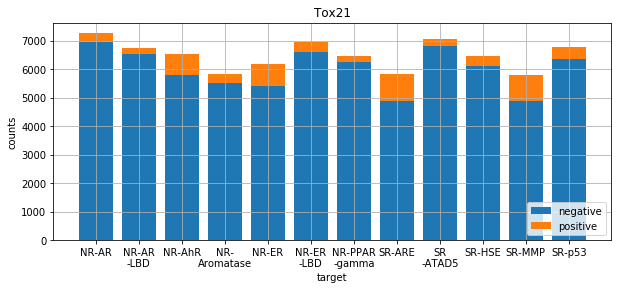

In [23]:
keys = df.keys()[:-2]
neg = [(df[k]==0).sum() for k in keys]
pos = [(df[k]==1).sum() for k in keys]
keys = ['NR-AR', 'NR-AR\n-LBD', 'NR-AhR', 'NR-\nAromatase', 'NR-ER', 'NR-ER\n-LBD',
       'NR-PPAR\n-gamma', 'SR-ARE', 'SR\n-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
plt.figure(figsize=(10,4))
bot = np.zeros(12)
plt.bar(keys, neg, bottom=bot, label='negative')
bot += neg
plt.bar(keys, pos, bottom=bot, label='positive')
plt.xlabel('target')
plt.ylabel('counts')
plt.title('Tox21')
plt.legend(loc='lower right')
plt.grid()
plt.show()

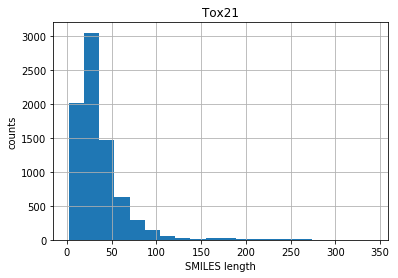

In [24]:
plt.hist(list(map(len, df['smiles'].values)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('Tox21')
plt.grid()
plt.show()

### ST

In [69]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

SMILES is too long (231)
SMILES is too long (263)
SMILES is too long (277)
SMILES is too long (219)
SMILES is too long (325)
SMILES is too long (243)
SMILES is too long (271)
SMILES is too long (255)
SMILES is too long (251)
SMILES is too long (235)
SMILES is too long (227)
SMILES is too long (251)
SMILES is too long (248)
SMILES is too long (264)
SMILES is too long (311)
SMILES is too long (251)
SMILES is too long (340)
SMILES is too long (230)
SMILES is too long (306)
SMILES is too long (284)
SMILES is too long (233)
SMILES is too long (221)
SMILES is too long (253)
SMILES is too long (225)
SMILES is too long (264)
SMILES is too long (271)
SMILES is too long (226)
SMILES is too long (275)
SMILES is too long (225)
SMILES is too long (273)
There are 7831 molecules. It will take a little time.
(7831, 1024)


In [72]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.636819427877498, 'auc std': 0.01676340515187386}
0.025 {'auc mean': 0.6684521844401683, 'auc std': 0.012557862868813125}
0.05 {'auc mean': 0.6846717726308414, 'auc std': 0.00864439698734144}
0.1 {'auc mean': 0.7079399575844314, 'auc std': 0.00495250460888231}
0.2 {'auc mean': 0.7291339046290648, 'auc std': 0.005785632700826855}
0.4 {'auc mean': 0.7482154551803918, 'auc std': 0.004880373911126395}
0.8 {'auc mean': 0.7656235408192239, 'auc std': 0.007142937854245916}


### ECFP4

In [73]:
x,X,_ = extract_morgan(df['smiles'].values, df['smiles'].values,)
print(len(X))

7831


In [74]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.48852397825172256, 'auc std': 0.011588580474552695}
0.025 {'auc mean': 0.5201946445247954, 'auc std': 0.011913936013996974}
0.05 {'auc mean': 0.575155846321433, 'auc std': 0.007810621158148587}
0.1 {'auc mean': 0.6140548327403642, 'auc std': 0.005187929036653902}
0.2 {'auc mean': 0.6600481309136884, 'auc std': 0.004687217174901597}
0.4 {'auc mean': 0.7065901958998645, 'auc std': 0.005143655434537728}
0.8 {'auc mean': 0.7472649974128428, 'auc std': 0.01234630120358285}


### RNN Seq2seq

In [75]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = rnn.encode(torch.t(xid))
print(X.shape)

SMILES is too long (231)
SMILES is too long (263)
SMILES is too long (277)
SMILES is too long (219)
SMILES is too long (325)
SMILES is too long (243)
SMILES is too long (271)
SMILES is too long (255)
SMILES is too long (251)
SMILES is too long (235)
SMILES is too long (227)
SMILES is too long (251)
SMILES is too long (248)
SMILES is too long (264)
SMILES is too long (311)
SMILES is too long (251)
SMILES is too long (340)
SMILES is too long (230)
SMILES is too long (306)
SMILES is too long (284)
SMILES is too long (233)
SMILES is too long (221)
SMILES is too long (253)
SMILES is too long (225)
SMILES is too long (264)
SMILES is too long (271)
SMILES is too long (226)
SMILES is too long (275)
SMILES is too long (225)
SMILES is too long (273)
There are 7831 molecules. It will take a little time.
(7831, 1024)


In [76]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.6425397056215969, 'auc std': 0.013041654093995379}
0.025 {'auc mean': 0.6596280092234303, 'auc std': 0.010864263924597203}
0.05 {'auc mean': 0.674127567558211, 'auc std': 0.010145977744031602}
0.1 {'auc mean': 0.7024737660919766, 'auc std': 0.004748314014680404}
0.2 {'auc mean': 0.7234471851312214, 'auc std': 0.005289071215204893}
0.4 {'auc mean': 0.7423479849618777, 'auc std': 0.004875955625707662}
0.8 {'auc mean': 0.7708396064574479, 'auc std': 0.007089837444937812}


### GraphConv

In [13]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks= list(KEYS.values),
      smiles_field='smiles',
      featurizer=featurizer)
dataset = loader.featurize('data/tox21.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/tox21.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 30.271 s
TIMING: dataset construction took 36.664 s
Loading dataset from disk.


In [15]:
for rate in rates:
    score_dic = evaluate_classification_multi_dc(dataset, rate, 20)
    print(rate, score_dic)

TIMING: dataset construction took 0.079 s
Loading dataset from disk.
TIMING: dataset construction took 6.173 s
Loading dataset from disk.
TIMING: dataset construction took 6.092 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.5600142967930815, 0.48935612632794234, 0.6911199726940132, 0.4070935524032063, 0.5391862230587823, 0.45584793493806897, 0.5494015138179897, 0.5230883478603314, 0.5920221282877762, 0.5552076169342417, 0.641595570515537, 0.533645457054508]
TIMING: dataset construction took 0.163 s
Loading dataset from disk.
TIMING: dataset construction took 6.261 s
Loading dataset from disk.
TIMING: dataset construction took 6.080 s
Loading dataset from disk.
computed_metrics: [0.7014714379179376, 0.6254600478673955, 0.6943003800254366, 0.4327490214015037, 0.5595600609500431, 0.5905312529125949, 0.4091978120955613, 0.5340600307592184, 0.4138491299678744, 0.5035945428210569, 0.6065030967781199, 0.4522911372755337]
TIMING: dataset construction took 0.092 s
Loading dataset from disk.
TIMING: dataset construction took 6.306 s
Loading dataset from disk.
TIMING: dataset construction took 6.126 s
Loading dataset from disk.
computed_metrics: [0.714538835733385, 0.3670726780658596, 0.65971722

TIMING: dataset construction took 0.155 s
Loading dataset from disk.
TIMING: dataset construction took 6.077 s
Loading dataset from disk.
TIMING: dataset construction took 6.266 s
Loading dataset from disk.
computed_metrics: [0.7146076008187514, 0.6721014419683373, 0.6141383517529042, 0.43044585234085875, 0.52391061138339, 0.4912225478127453, 0.5785792918590899, 0.4824236621460857, 0.5333251194858131, 0.5139740006896749, 0.500611704982516, 0.49810512097030035]
TIMING: dataset construction took 0.146 s
Loading dataset from disk.
TIMING: dataset construction took 6.133 s
Loading dataset from disk.
TIMING: dataset construction took 6.081 s
Loading dataset from disk.
computed_metrics: [0.551849419611671, 0.35373747346596235, 0.6972478100038664, 0.5008163360291407, 0.5568758829537427, 0.5124521721765983, 0.5131053850432501, 0.6112909079473535, 0.5415947742535563, 0.5364401767928286, 0.6425847476406619, 0.4929501134219105]
0.0125 {'auc std': 0.02183641325412813, 'auc mean': 0.534207595122520

computed_metrics: [0.6943965984787002, 0.6815082026023909, 0.7307986018822237, 0.49444555666848805, 0.5750979966112706, 0.6328331604318294, 0.5150512802548114, 0.6346695831573691, 0.6508583167785641, 0.45078110729636134, 0.7057424532312924, 0.5996008542439359]
TIMING: dataset construction took 0.232 s
Loading dataset from disk.
TIMING: dataset construction took 6.267 s
Loading dataset from disk.
TIMING: dataset construction took 6.261 s
Loading dataset from disk.
computed_metrics: [0.5453355398458222, 0.5904480431957125, 0.7799484013884426, 0.5511954839721445, 0.5498489225293745, 0.5796886296618224, 0.4727697331036608, 0.6070474300443846, 0.5833573290891386, 0.5619102241631886, 0.6991166200459615, 0.5774677762656379]
TIMING: dataset construction took 0.139 s
Loading dataset from disk.
TIMING: dataset construction took 6.070 s
Loading dataset from disk.
TIMING: dataset construction took 6.106 s
Loading dataset from disk.
computed_metrics: [0.6352869837622845, 0.6669590051421187, 0.78143

TIMING: dataset construction took 0.465 s
Loading dataset from disk.
TIMING: dataset construction took 6.046 s
Loading dataset from disk.
TIMING: dataset construction took 6.040 s
Loading dataset from disk.
computed_metrics: [0.7240338829801347, 0.7306656021115332, 0.7715767274375503, 0.5757339471009842, 0.5711540669374252, 0.6759025906935875, 0.4074863654528785, 0.658786351780118, 0.6834532452880484, 0.5757936704160158, 0.7215014584272375, 0.6644999068060276]
TIMING: dataset construction took 0.474 s
Loading dataset from disk.
TIMING: dataset construction took 6.088 s
Loading dataset from disk.
TIMING: dataset construction took 6.038 s
Loading dataset from disk.
computed_metrics: [0.5951166180758019, 0.5599836105905253, 0.794703675029033, 0.6601970608211195, 0.6209847205869601, 0.6092923259274419, 0.565759003099819, 0.6467275227906184, 0.688140091391622, 0.5952720746943192, 0.7290003209712281, 0.6086142018697428]
TIMING: dataset construction took 0.353 s
Loading dataset from disk.
TIM

TIMING: dataset construction took 0.701 s
Loading dataset from disk.
TIMING: dataset construction took 5.695 s
Loading dataset from disk.
TIMING: dataset construction took 5.696 s
Loading dataset from disk.
computed_metrics: [0.7547536772831644, 0.7706154095099773, 0.8180652992550874, 0.6201381929132982, 0.6492314033556397, 0.7011956712863057, 0.5837828481257246, 0.6817181649449524, 0.6723243929791762, 0.5971145845139924, 0.7701561883960666, 0.7040739741972233]
TIMING: dataset construction took 0.706 s
Loading dataset from disk.
TIMING: dataset construction took 5.800 s
Loading dataset from disk.
TIMING: dataset construction took 5.691 s
Loading dataset from disk.
computed_metrics: [0.744495367616, 0.7597929710976776, 0.808860184404788, 0.7060044554713636, 0.651898893055368, 0.7317878946450376, 0.5529639938473601, 0.6796434714679126, 0.7011741000570302, 0.6072560994035895, 0.7810596975558534, 0.6439603832698819]
TIMING: dataset construction took 0.667 s
Loading dataset from disk.
TIMIN

TIMING: dataset construction took 1.270 s
Loading dataset from disk.
TIMING: dataset construction took 5.242 s
Loading dataset from disk.
TIMING: dataset construction took 5.226 s
Loading dataset from disk.
computed_metrics: [0.7720490337796713, 0.7706786703601107, 0.8491524931486596, 0.7868376450026887, 0.6899104930367441, 0.7502378170894526, 0.6247130959626971, 0.7202523096760152, 0.6944461600222338, 0.6672002332343643, 0.8309401893815802, 0.7615102393918767]
TIMING: dataset construction took 1.374 s
Loading dataset from disk.
TIMING: dataset construction took 5.356 s
Loading dataset from disk.
TIMING: dataset construction took 5.288 s
Loading dataset from disk.
computed_metrics: [0.7886148648648649, 0.8143365535167884, 0.8289673900629215, 0.7493687008018832, 0.7012991680116996, 0.7406466106597249, 0.6649936499437529, 0.7274227454418822, 0.7698124011855929, 0.64065859605031, 0.8151194200307861, 0.7199700570635721]
TIMING: dataset construction took 1.548 s
Loading dataset from disk.
T

TIMING: dataset construction took 2.775 s
Loading dataset from disk.
TIMING: dataset construction took 4.059 s
Loading dataset from disk.
TIMING: dataset construction took 3.914 s
Loading dataset from disk.
computed_metrics: [0.7753368621772809, 0.8148918401691163, 0.8587899789982834, 0.7988627384580653, 0.7185308215557044, 0.7904441916139278, 0.7414697053520203, 0.747954045509886, 0.796065034764641, 0.7047419903600793, 0.8650837803224054, 0.7760442318185441]
TIMING: dataset construction took 2.759 s
Loading dataset from disk.
TIMING: dataset construction took 3.798 s
Loading dataset from disk.
TIMING: dataset construction took 3.797 s
Loading dataset from disk.
computed_metrics: [0.8146642984411461, 0.8489369529192539, 0.8582149816432327, 0.7890459835416452, 0.70212439235784, 0.7837252571812694, 0.7379518712034323, 0.7427759803869967, 0.7907196194639565, 0.7054218239019745, 0.8553573322949269, 0.7647852560207515]
TIMING: dataset construction took 2.516 s
Loading dataset from disk.
TIM

TIMING: dataset construction took 5.006 s
Loading dataset from disk.
TIMING: dataset construction took 1.318 s
Loading dataset from disk.
TIMING: dataset construction took 1.333 s
Loading dataset from disk.
computed_metrics: [0.7682185777536821, 0.7858406895403065, 0.8543450953522896, 0.8379585326953748, 0.710639798372179, 0.8071238095238095, 0.7033374306253957, 0.775918093014559, 0.7526511499793418, 0.7770874861572536, 0.8562139667952664, 0.7689862327909888]
TIMING: dataset construction took 5.228 s
Loading dataset from disk.
TIMING: dataset construction took 1.330 s
Loading dataset from disk.
TIMING: dataset construction took 1.282 s
Loading dataset from disk.
computed_metrics: [0.788648368232409, 0.7962139585017516, 0.8843675300032036, 0.8296856978085352, 0.7304799170954832, 0.7897327852004111, 0.8077657846976789, 0.8205210209451991, 0.8664831160417847, 0.7891040537051381, 0.8907954259864288, 0.8226937877954921]
TIMING: dataset construction took 5.097 s
Loading dataset from disk.
TI

### BERT

In [78]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)
X = bert.encode(xid, xseg)
print(X.shape)

SMILES is too long (231)
SMILES is too long (263)
SMILES is too long (277)
SMILES is too long (219)
SMILES is too long (325)
SMILES is too long (243)
SMILES is too long (271)
SMILES is too long (255)
SMILES is too long (251)
SMILES is too long (235)
SMILES is too long (227)
SMILES is too long (251)
SMILES is too long (248)
SMILES is too long (264)
SMILES is too long (311)
SMILES is too long (251)
SMILES is too long (340)
SMILES is too long (230)
SMILES is too long (306)
SMILES is too long (284)
SMILES is too long (233)
SMILES is too long (221)
SMILES is too long (253)
SMILES is too long (225)
SMILES is too long (264)
SMILES is too long (271)
SMILES is too long (226)
SMILES is too long (275)
SMILES is too long (225)
SMILES is too long (273)
There are 7831 molecules. It will take a little time.
(7831, 1024)


In [79]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.6010158416922666, 'auc std': 0.023240420841334274}


/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged 

0.025 {'auc mean': 0.609843745459462, 'auc std': 0.02325644212925572}
0.05 {'auc mean': 0.6932080977569708, 'auc std': 0.009283212001007193}
0.1 {'auc mean': 0.7262284131046333, 'auc std': 0.006020303461160268}
0.2 {'auc mean': 0.7442901406703255, 'auc std': 0.004469625227936093}
0.4 {'auc mean': 0.7580719165187659, 'auc std': 0.004558186870771946}
0.8 {'auc mean': 0.7719572345425985, 'auc std': 0.00501484117852729}


## SIDER

In [12]:
df = pd.read_csv('data/sider.csv')
KEYS  = df.keys()[1:]
print(df.shape)
df.head()

(1427, 28)


,smiles,Hepatobiliary disorders,Metabolism and nutrition disorders,Product issues,Eye disorders,Investigations,Musculoskeletal and connective tissue disorders,Gastrointestinal disorders,Social circumstances,Immune system disorders,...,"Congenital, familial and genetic disorders",Infections and infestations,"Respiratory, thoracic and mediastinal disorders",Psychiatric disorders,Renal and urinary disorders,"Pregnancy, puerperium and perinatal conditions",Ear and labyrinth disorders,Cardiac disorders,Nervous system disorders,"Injury, poisoning and procedural complications"
0,C(CNCCNCCNCCN)N,1,1,0,0,1,1,1,0,0,...,0,0,1,1,0,0,1,1,1,0
1,CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=...,0,1,0,0,1,1,1,0,0,...,0,1,1,0,0,0,1,0,1,0
2,CC[C@]12CC(=C)[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O...,0,1,0,1,1,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
3,CCC12CC(=C)C3C(C1CC[C@]2(C#C)O)CCC4=CC(=O)CCC34,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,0,0,1,1
4,C1C(C2=CC=CC=C2N(C3=CC=CC=C31)C(=O)N)O,1,1,0,1,1,1,1,0,1,...,0,1,1,1,0,0,1,0,1,0


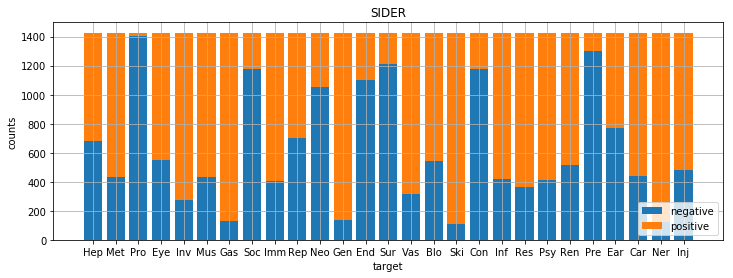

In [13]:
keys = df.keys()[1:]
neg = [(df[k]==0).sum() for k in keys]
pos = [(df[k]==1).sum() for k in keys]
plt.figure(figsize=(12,4))
keys = [k[:3] for k in keys]
bot = np.zeros(len(keys))
plt.bar(keys, neg, bottom=bot, label='negative')
bot += neg
plt.bar(keys, pos, bottom=bot, label='positive')
plt.xlabel('target')
plt.ylabel('counts')
plt.title('SIDER')
plt.legend(loc='lower right')
plt.grid()
plt.show()

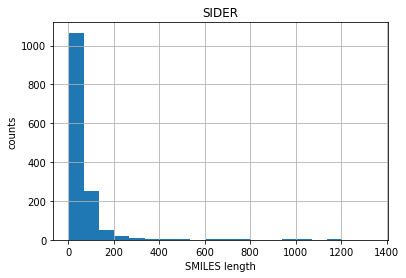

In [14]:
plt.hist(list(map(len, df['smiles'].values)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('SIDER')
plt.grid()
plt.show()

### ST

In [9]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

SMILES is too long (1031)
SMILES is too long (788)
SMILES is too long (1179)
SMILES is too long (384)
SMILES is too long (246)
SMILES is too long (801)
SMILES is too long (236)
SMILES is too long (306)
SMILES is too long (512)
SMILES is too long (661)
SMILES is too long (1079)
SMILES is too long (704)
SMILES is too long (220)
SMILES is too long (749)
SMILES is too long (615)
SMILES is too long (832)
SMILES is too long (244)
SMILES is too long (1001)
SMILES is too long (1195)
SMILES is too long (704)
SMILES is too long (282)
SMILES is too long (467)
SMILES is too long (227)
SMILES is too long (331)
SMILES is too long (238)
SMILES is too long (548)
SMILES is too long (259)
SMILES is too long (531)
SMILES is too long (389)
SMILES is too long (626)
SMILES is too long (889)
SMILES is too long (270)
SMILES is too long (1006)
SMILES is too long (273)
SMILES is too long (247)
SMILES is too long (990)
SMILES is too long (253)
SMILES is too long (314)
SMILES is too long (444)
SMILES is too long 

In [10]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.5256172998491813, 'auc std': 0.009327074848106227}
0.025 {'auc mean': 0.5324077768793416, 'auc std': 0.011787773165028652}
0.05 {'auc mean': 0.5441177379245871, 'auc std': 0.006966903765198338}
0.1 {'auc mean': 0.5583409954583286, 'auc std': 0.005102843754746479}
0.2 {'auc mean': 0.5687384209552709, 'auc std': 0.005478971601816549}
0.4 {'auc mean': 0.5824164366710604, 'auc std': 0.005062924664440607}
0.8 {'auc mean': 0.6043440615316215, 'auc std': 0.008727982077987785}


### ECFP4

In [11]:
x,X,_ = extract_morgan(df['smiles'].values, df['smiles'].values,)
print(len(X))

1427


In [12]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.5514793112380094, 'auc std': 0.004530055245347764}
0.025 {'auc mean': 0.5589578501366791, 'auc std': 0.004534084472119589}
0.05 {'auc mean': 0.570089506491246, 'auc std': 0.005035395945620036}
0.1 {'auc mean': 0.582829188677217, 'auc std': 0.004262473585821782}
0.2 {'auc mean': 0.5974733632037447, 'auc std': 0.0033663020891329634}
0.4 {'auc mean': 0.6154061633807567, 'auc std': 0.005271349325392699}
0.8 {'auc mean': 0.6363932687272557, 'auc std': 0.008875670046783225}


### RNNSeq2seq

In [13]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = rnn.encode(torch.t(xid))
print(X.shape)

SMILES is too long (1031)
SMILES is too long (788)
SMILES is too long (1179)
SMILES is too long (384)
SMILES is too long (246)
SMILES is too long (801)
SMILES is too long (236)
SMILES is too long (306)
SMILES is too long (512)
SMILES is too long (661)
SMILES is too long (1079)
SMILES is too long (704)
SMILES is too long (220)
SMILES is too long (749)
SMILES is too long (615)
SMILES is too long (832)
SMILES is too long (244)
SMILES is too long (1001)
SMILES is too long (1195)
SMILES is too long (704)
SMILES is too long (282)
SMILES is too long (467)
SMILES is too long (227)
SMILES is too long (331)
SMILES is too long (238)
SMILES is too long (548)
SMILES is too long (259)
SMILES is too long (531)
SMILES is too long (389)
SMILES is too long (626)
SMILES is too long (889)
SMILES is too long (270)
SMILES is too long (1006)
SMILES is too long (273)
SMILES is too long (247)
SMILES is too long (990)
SMILES is too long (253)
SMILES is too long (314)
SMILES is too long (444)
SMILES is too long 

In [14]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.5247333844786712, 'auc std': 0.0071151371866655065}
0.025 {'auc mean': 0.528438737962658, 'auc std': 0.0067549726230368016}
0.05 {'auc mean': 0.5403389640550995, 'auc std': 0.0064322762469103}
0.1 {'auc mean': 0.5500568705565965, 'auc std': 0.005951971070907419}


/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged 

0.2 {'auc mean': 0.5662190224495347, 'auc std': 0.004801851693343641}
0.4 {'auc mean': 0.5845393377043444, 'auc std': 0.004621508328278725}
0.8 {'auc mean': 0.6091705950741559, 'auc std': 0.006388730134388776}


### GraphConv

In [29]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks= list(KEYS.values),
      smiles_field='smiles',
      featurizer=featurizer)
dataset = loader.featurize('data/sider.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/sider.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 8.269 s
TIMING: dataset construction took 10.049 s
Loading dataset from disk.


In [34]:
for rate in rates:
    score_dic = evaluate_classification_multi_dc(dataset, rate, 20)
    print(rate, score_dic)

TIMING: dataset construction took 0.036 s
Loading dataset from disk.
TIMING: dataset construction took 1.719 s
Loading dataset from disk.
TIMING: dataset construction took 1.632 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.469252789671727, 0.5286755547187301, 0.49893162393162394, 0.5580259358027212, 0.49636508388016465, 0.43500947954253566, 0.6150669836317262, 0.4408671433322248, 0.5003185949960673, 0.491448041612188, 0.45798146480797297, 0.5387243054392303, 0.5510788230603987, 0.46439977604466487, 0.5628002134851451, 0.5319708938275436, 0.6566961202948182, 0.43946086956521735, 0.6139213924322635, 0.4887801273124063, 0.484152719148221, 0.5265810276679842, 0.4581439817229135, 0.4883009293597428, 0.5667811513892096, 0.6266951345755694, 0.5081431334622823]
TIMING: dataset construction took 0.034 s
Loading dataset from disk.
TIMING: dataset construction took 1.682 s
Loading dataset from disk.
TIMING: dataset construction took 1.654 s
Loading dataset from disk.
computed_metrics: [0.531329103719588, 0.4559688506672802, 0.44166019166019166, 0.5403631208537883, 0.564135033286469, 0.5898459325479379, 0.5466037689126613, 0.5124279091586412, 0.5712874082439301, 0.575632182981348, 0.479012374371

TIMING: dataset construction took 0.030 s
Loading dataset from disk.
TIMING: dataset construction took 1.678 s
Loading dataset from disk.
TIMING: dataset construction took 1.693 s
Loading dataset from disk.
computed_metrics: [0.470574639937719, 0.5671250700036692, 0.4834563584563585, 0.45964439331370144, 0.5913309561138516, 0.5210455409339139, 0.5577960126279067, 0.45491730747876297, 0.5633300395256917, 0.5094449528155474, 0.5119946753515302, 0.5505353312748957, 0.5168017255865429, 0.5369901847826517, 0.5288812785388128, 0.4305165391577581, 0.6199098629104716, 0.5171750433275564, 0.4622177509501453, 0.5067228091341307, 0.4969972327439013, 0.50871643745907, 0.49045450019912384, 0.49615365052237514, 0.5527604226374718, 0.6196582567629999, 0.5596789177920782]
TIMING: dataset construction took 0.031 s
Loading dataset from disk.
TIMING: dataset construction took 1.700 s
Loading dataset from disk.
TIMING: dataset construction took 1.642 s
Loading dataset from disk.
computed_metrics: [0.50320

TIMING: dataset construction took 0.085 s
Loading dataset from disk.
TIMING: dataset construction took 1.753 s
Loading dataset from disk.
TIMING: dataset construction took 1.627 s
Loading dataset from disk.
computed_metrics: [0.4935687577897798, 0.5570414740701735, 0.4298433048433048, 0.4414056746805285, 0.5081861217327536, 0.44297218209067246, 0.5370818045151098, 0.5066965379633843, 0.5692106247661803, 0.43398966234924263, 0.4515023271449225, 0.5403065551920514, 0.4755484548587997, 0.5239545367350853, 0.598139322474502, 0.5486891792886197, 0.6313418820974794, 0.5266891073159605, 0.4910155703463852, 0.5651197243847683, 0.5073164780251482, 0.5249115471568018, 0.4869023498144883, 0.5681788920610722, 0.5182447748578454, 0.5700874689498441, 0.5286384211396147]
TIMING: dataset construction took 0.097 s
Loading dataset from disk.
TIMING: dataset construction took 1.687 s
Loading dataset from disk.
TIMING: dataset construction took 1.707 s
Loading dataset from disk.
computed_metrics: [0.45586

TIMING: dataset construction took 0.103 s
Loading dataset from disk.
TIMING: dataset construction took 1.732 s
Loading dataset from disk.
TIMING: dataset construction took 1.721 s
Loading dataset from disk.
computed_metrics: [0.564208771747057, 0.5166610192796881, 0.41278166278166284, 0.4594038154061809, 0.5204266816545849, 0.4721618309747806, 0.6168593996840444, 0.4415666002548777, 0.5547269634673233, 0.5262109699754725, 0.49906945153794524, 0.4863186813186814, 0.40488977072310406, 0.49919379347605863, 0.5628348171128912, 0.5635736598390089, 0.654413275037413, 0.5355048675170345, 0.5744251897157095, 0.5329052333650242, 0.49872666498486384, 0.5292181663664788, 0.46557377049180326, 0.5359828430561531, 0.4681704139727878, 0.6880384229163363, 0.5562491078720203]
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
TIMING: dataset construction took 1.709 s
Loading dataset from disk.
TIMING: dataset construction took 1.723 s
Loading dataset from disk.
computed_metrics: [0.56

TIMING: dataset construction took 0.249 s
Loading dataset from disk.
TIMING: dataset construction took 1.617 s
Loading dataset from disk.
TIMING: dataset construction took 1.593 s
Loading dataset from disk.
computed_metrics: [0.570501619408188, 0.4861949492243114, 0.45144936063387464, 0.5130020512141864, 0.5804832158430491, 0.45625610567229946, 0.4564140000267892, 0.48186194365310275, 0.5908508795058194, 0.523373143656241, 0.5085920193167387, 0.5201773434672458, 0.46726241499514254, 0.545416919720179, 0.5306324142482335, 0.5045191382141441, 0.6043188654920499, 0.5479590413844826, 0.5483907306083038, 0.5194105334514685, 0.5462945267293093, 0.5174231840256988, 0.5134043334557473, 0.5080164526147906, 0.5366103832557507, 0.6305471051233762, 0.459263406774842]
TIMING: dataset construction took 0.105 s
Loading dataset from disk.
TIMING: dataset construction took 1.696 s
Loading dataset from disk.
TIMING: dataset construction took 1.654 s
Loading dataset from disk.
computed_metrics: [0.519753

TIMING: dataset construction took 0.109 s
Loading dataset from disk.
TIMING: dataset construction took 1.679 s
Loading dataset from disk.
TIMING: dataset construction took 1.643 s
Loading dataset from disk.
computed_metrics: [0.550379657187937, 0.4933325715666651, 0.47557249287602565, 0.49788660711432864, 0.5253423307165646, 0.5457578545519918, 0.6146474878444084, 0.4924137519175572, 0.48411205101852584, 0.5824280134536426, 0.504945530726257, 0.5046888224883941, 0.48363650195781305, 0.4551741139167874, 0.563420187040496, 0.5619785873192435, 0.6883122016594136, 0.5131896280539868, 0.5086003610221308, 0.5023108588716196, 0.537488908606921, 0.5184306993375096, 0.41765663920291246, 0.5121982445290716, 0.5294269376830805, 0.6467908902691512, 0.5097447521143226]
TIMING: dataset construction took 0.100 s
Loading dataset from disk.
TIMING: dataset construction took 1.949 s
Loading dataset from disk.
TIMING: dataset construction took 1.625 s
Loading dataset from disk.
computed_metrics: [0.55031

TIMING: dataset construction took 0.183 s
Loading dataset from disk.
TIMING: dataset construction took 1.565 s
Loading dataset from disk.
TIMING: dataset construction took 1.565 s
Loading dataset from disk.
computed_metrics: [0.5866094285763375, 0.549080909083133, 0.39583660644147683, 0.5574453121640117, 0.5959607360817039, 0.5585717548969219, 0.5188123153452998, 0.5194009530292716, 0.5204261052936876, 0.6024316182964156, 0.5505821103929129, 0.4873365070710037, 0.5576214387502354, 0.5167042476102375, 0.5292002444605524, 0.606780581821004, 0.6870391439911759, 0.4738078749505342, 0.545296755081266, 0.5759035013611189, 0.5541405109214349, 0.5116205962059621, 0.5215260504697867, 0.4802970604389044, 0.5904840103716509, 0.6915341661934507, 0.5444098385540339]
TIMING: dataset construction took 0.283 s
Loading dataset from disk.
TIMING: dataset construction took 1.540 s
Loading dataset from disk.
TIMING: dataset construction took 1.551 s
Loading dataset from disk.
computed_metrics: [0.58601940

TIMING: dataset construction took 0.224 s
Loading dataset from disk.
TIMING: dataset construction took 1.659 s
Loading dataset from disk.
TIMING: dataset construction took 1.667 s
Loading dataset from disk.
computed_metrics: [0.5810936721474838, 0.5483929632816729, 0.4960564399421129, 0.5455475384968513, 0.5777224017019935, 0.5172144200699309, 0.609784292419023, 0.4456523666802632, 0.5630890100074737, 0.5801502250929731, 0.4733147601879165, 0.5521454525282223, 0.5471620816826281, 0.5544980177238805, 0.5878775094047743, 0.5771788336239936, 0.5446549084617406, 0.5034727581416885, 0.5841437202277217, 0.5624741180733495, 0.5154856337035079, 0.5751936564430022, 0.539110191020012, 0.5098695590736112, 0.4931020502722113, 0.693546179119007, 0.5150984089126676]
TIMING: dataset construction took 0.183 s
Loading dataset from disk.
TIMING: dataset construction took 1.572 s
Loading dataset from disk.
TIMING: dataset construction took 1.621 s
Loading dataset from disk.
computed_metrics: [0.592448454

TIMING: dataset construction took 0.327 s
Loading dataset from disk.
TIMING: dataset construction took 1.516 s
Loading dataset from disk.
TIMING: dataset construction took 1.468 s
Loading dataset from disk.
computed_metrics: [0.5982099168781436, 0.5553754307265817, 0.3966384023723473, 0.5497397677562762, 0.5813628503639361, 0.6054317079247826, 0.5536286655305471, 0.5485138938194241, 0.5457392351701295, 0.5733359014809651, 0.5167128410871873, 0.56845997158556, 0.5601204109678686, 0.4844826878295705, 0.5625025468276714, 0.6175391060378954, 0.645921382771118, 0.4604381810318457, 0.6018525832046817, 0.5674726217179047, 0.554453127612847, 0.5488369516697131, 0.4712801350048216, 0.5836148648648649, 0.6171581628633702, 0.6795265733469898, 0.533730793297643]
TIMING: dataset construction took 0.353 s
Loading dataset from disk.
TIMING: dataset construction took 1.410 s
Loading dataset from disk.
TIMING: dataset construction took 1.425 s
Loading dataset from disk.
computed_metrics: [0.63350240096

TIMING: dataset construction took 0.404 s
Loading dataset from disk.
TIMING: dataset construction took 1.526 s
Loading dataset from disk.
TIMING: dataset construction took 1.531 s
Loading dataset from disk.
computed_metrics: [0.639294591075867, 0.5390231751420769, 0.5153065575168415, 0.5672329982219038, 0.5178111939077537, 0.5735523401527074, 0.6305960735210294, 0.5228587535370453, 0.5268254090768756, 0.6146802839066063, 0.5166333106512428, 0.5523105502039566, 0.5599076909421736, 0.5356774288662833, 0.5300067643742954, 0.6077779541936252, 0.621960829098384, 0.5698846443804154, 0.5611113177371965, 0.573866269447203, 0.5736982369823698, 0.5841038475097471, 0.4623500491642084, 0.5438491478807524, 0.5654844409242533, 0.6971677559912854, 0.5694296513517814]
0.2 {'auc std': 0.006370035325254813, 'auc mean': 0.5605487301897695}
TIMING: dataset construction took 0.705 s
Loading dataset from disk.
TIMING: dataset construction took 1.200 s
Loading dataset from disk.
TIMING: dataset construction 

TIMING: dataset construction took 0.697 s
Loading dataset from disk.
TIMING: dataset construction took 1.049 s
Loading dataset from disk.
TIMING: dataset construction took 1.062 s
Loading dataset from disk.
computed_metrics: [0.6536012843935116, 0.5226156581417613, 0.4294236562549548, 0.5994992420288774, 0.5770482366016103, 0.586038714662178, 0.5775511394895221, 0.5929176864382377, 0.5846991189577168, 0.5931562982278751, 0.5962441972988514, 0.5041207144569648, 0.5894190042355949, 0.5486299818840581, 0.5728931704260651, 0.6088576376134753, 0.6289174263091358, 0.5061103613735193, 0.6095652638325144, 0.5588381330685204, 0.5348536071952542, 0.6187484716869083, 0.5557723577235771, 0.541993620414673, 0.5897878348170517, 0.6688640973630833, 0.5788118390055637]
TIMING: dataset construction took 0.707 s
Loading dataset from disk.
TIMING: dataset construction took 1.052 s
Loading dataset from disk.
TIMING: dataset construction took 1.064 s
Loading dataset from disk.
computed_metrics: [0.60596030

TIMING: dataset construction took 1.375 s
Loading dataset from disk.
TIMING: dataset construction took 0.484 s
Loading dataset from disk.
TIMING: dataset construction took 0.465 s
Loading dataset from disk.
computed_metrics: [0.7048147067405894, 0.6026162790697674, 0.3945288753799392, 0.6134680134680135, 0.6513548180214848, 0.6409090909090909, 0.6382783882783882, 0.5709513435003631, 0.6461788617886179, 0.6157741801577417, 0.6364676513417933, 0.6212906784335356, 0.628062066688676, 0.5177815072324783, 0.5872603372603372, 0.6773218356626028, 0.7916666666666666, 0.5133837767472134, 0.5973597359735974, 0.6500967585873246, 0.6341463414634146, 0.6358834244080147, 0.507780678851175, 0.5531531531531532, 0.5575873679321954, 0.7372531682876511, 0.5842571029343269]
TIMING: dataset construction took 1.456 s
Loading dataset from disk.
TIMING: dataset construction took 0.352 s
Loading dataset from disk.
TIMING: dataset construction took 0.350 s
Loading dataset from disk.
computed_metrics: [0.64689168

TIMING: dataset construction took 1.400 s
Loading dataset from disk.
TIMING: dataset construction took 0.341 s
Loading dataset from disk.
TIMING: dataset construction took 0.364 s
Loading dataset from disk.
computed_metrics: [0.6505565559011295, 0.6075531914893617, 0.530921052631579, 0.5573593073593074, 0.6598908338038774, 0.6006701030927835, 0.7392976588628764, 0.6377108983128135, 0.6399624765478424, 0.6450112451441423, 0.6033200088829669, 0.5657979407979408, 0.6578112609040443, 0.5397617697107204, 0.5608400608400608, 0.6624655946689846, 0.7768445322793149, 0.5236498108015135, 0.554990634198555, 0.5326415094339623, 0.6403114186851211, 0.6777007145859605, 0.581793103448276, 0.5909599349196665, 0.613179992698065, 0.7294343024566148, 0.6032748538011696]
TIMING: dataset construction took 1.369 s
Loading dataset from disk.
TIMING: dataset construction took 0.469 s
Loading dataset from disk.
TIMING: dataset construction took 0.503 s
Loading dataset from disk.
computed_metrics: [0.6955581066

### BERT

In [17]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)
X = bert.encode(xid, xseg)
print(X.shape)

SMILES is too long (1031)
SMILES is too long (788)
SMILES is too long (1179)
SMILES is too long (384)
SMILES is too long (246)
SMILES is too long (801)
SMILES is too long (236)
SMILES is too long (306)
SMILES is too long (512)
SMILES is too long (661)
SMILES is too long (1079)
SMILES is too long (704)
SMILES is too long (220)
SMILES is too long (749)
SMILES is too long (615)
SMILES is too long (832)
SMILES is too long (244)
SMILES is too long (1001)
SMILES is too long (1195)
SMILES is too long (704)
SMILES is too long (282)
SMILES is too long (467)
SMILES is too long (227)
SMILES is too long (331)
SMILES is too long (238)
SMILES is too long (548)
SMILES is too long (259)
SMILES is too long (531)
SMILES is too long (389)
SMILES is too long (626)
SMILES is too long (889)
SMILES is too long (270)
SMILES is too long (1006)
SMILES is too long (273)
SMILES is too long (247)
SMILES is too long (990)
SMILES is too long (253)
SMILES is too long (314)
SMILES is too long (444)
SMILES is too long 

In [19]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.5159862072396973, 'auc std': 0.010242381425175107}
0.025 {'auc mean': 0.5319403529308495, 'auc std': 0.006684946733821753}


/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged 

0.05 {'auc mean': 0.5362092315996206, 'auc std': 0.007952321933657141}


/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged 

0.1 {'auc mean': 0.5488136946934671, 'auc std': 0.0063319851307063035}
0.2 {'auc mean': 0.5732072272644789, 'auc std': 0.004495625316498007}
0.4 {'auc mean': 0.5885331910521647, 'auc std': 0.0046245790834997386}
0.8 {'auc mean': 0.597753895604088, 'auc std': 0.007893792418320174}


## ClinTox

In [20]:
df = pd.read_csv('data/clintox.csv')
KEYS  = df.keys()[1:]
print(df.shape)
df.head()

(1484, 3)


,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


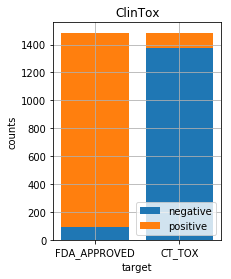

In [21]:
keys = df.keys()[1:]
neg = [(df[k]==0).sum() for k in keys]
pos = [(df[k]==1).sum() for k in keys]
plt.figure(figsize=(3,4))
bot = np.zeros(len(keys))
plt.bar(keys, neg, bottom=bot, label='negative')
bot += neg
plt.bar(keys, pos, bottom=bot, label='positive')
plt.xlabel('target')
plt.ylabel('counts')
plt.title('ClinTox')
plt.legend(loc='lower right')
plt.grid()
plt.show()

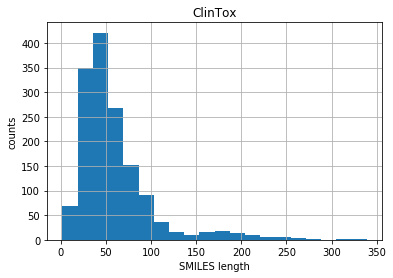

In [22]:
plt.hist(list(map(len, df['smiles'].values)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('ClinTox')
plt.grid()
plt.show()

### ST

In [23]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)

SMILES is too long (219)
SMILES is too long (263)
SMILES is too long (318)
SMILES is too long (238)
SMILES is too long (230)
SMILES is too long (227)
SMILES is too long (261)
SMILES is too long (227)
SMILES is too long (279)
SMILES is too long (255)
SMILES is too long (271)
SMILES is too long (253)
SMILES is too long (253)
SMILES is too long (251)
SMILES is too long (221)
SMILES is too long (225)
SMILES is too long (284)
SMILES is too long (314)
SMILES is too long (236)
SMILES is too long (240)
SMILES is too long (339)
There are 1484 molecules. It will take a little time.
(1484, 1024)


In [24]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.9302798278197567, 'auc std': 0.037199597680700046}
0.025 {'auc mean': 0.9481876623231443, 'auc std': 0.014987221801032081}
0.05 {'auc mean': 0.9635442452711157, 'auc std': 0.005898416483958611}
0.1 {'auc mean': 0.9683355930164179, 'auc std': 0.007479499787458779}
0.2 {'auc mean': 0.973179667243282, 'auc std': 0.0051722411301356125}
0.4 {'auc mean': 0.9787603493047028, 'auc std': 0.0056559923801398106}
0.8 {'auc mean': 0.9818157002888336, 'auc std': 0.008691620113166038}


### ECFP4

In [31]:
def extract_morgan_multi(smiles, targets):
    x,X,y = [],[],[]
    for sm,target in zip(smiles,targets):
        mol = Chem.MolFromSmiles(sm)
        if mol is None:
            print(sm)
            continue
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) # Morgan (Similar to ECFP4)
        x.append(sm)
        X.append(bit2np(fp))
        y.append(target)
    return x,np.array(X),np.array(y) 

In [35]:
x,X,y = extract_morgan(df['smiles'].values, np.array([df['FDA_APPROVED'].values, df['CT_TOX'].values]).T)
print(len(X))

[NH4][Pt]([NH4])(Cl)Cl
c1ccc(cc1)n2c(=O)c(c(=O)n2c3ccccc3)CCS(=O)c4ccccc4
Cc1cc2c(cc1C)N3C=N2[Co+]456(N7=C8[C@H](C(C7=CC9=N4C(=C(C1=N5[C@@]([C@@H]2N6C(=C8C)[C@@]([C@H]2CC(=O)N)(CCC(=O)NC[C@H](OP(=O)(O[C@@H]2[C@H](O[C@H]3[C@@H]2O)CO)[O-])C)C)([C@@]([C@@H]1CCC(=O)N)(C)CC(=O)N)C)C)[C@@]([C@@H]9CCC(=O)N)(C)CC(=O)N)(C)C)CCC(=O)N)O
Cc1cc2c(cc1C)N3C=N2[Co]456(N7=C8[C@H](C(C7=CC9=N4C(=C(C1=N5[C@@]([C@@H]2N6C(=C8C)[C@@]([C@H]2CC(=O)N)(CCC(=O)NC[C@H](OP(=O)(O[C@@H]2[C@H](O[C@H]3[C@@H]2O)CO)O)C)C)([C@@]([C@@H]1CCC(=O)N)(C)CC(=O)N)C)C)[C@@]([C@@H]9CCC(=O)N)(C)CC(=O)N)(C)C)CCC(=O)N)C#N
CCCCc1c(=O)n(n(c1=O)c2ccc(cc2)O)c3ccccc3
CCCCc1c(=O)n(n(c1=O)c2ccccc2)c3ccccc3
1478


In [39]:
def evaluate_mlp_classification_multi_(X, y, rate, n_repeats):
    auc = np.empty(n_repeats)
    for i in range(n_repeats):
        _auc = np.empty(len(KEYS))
        for j,key in enumerate(KEYS):
            X_dr = X
            y_dr = y[:,j]
            clf = MLPClassifier(max_iter=1000)
            X_train, X_test, y_train, y_test = train_test_split(X_dr, y_dr, test_size=1-rate, stratify=y_dr)
            clf.fit(X_train, y_train)
            y_score = clf.predict_proba(X_test)
            _auc[j] = roc_auc_score(y_test, y_score[:,1])
        auc[i] = np.mean(_auc)
    ret = {}
    ret['auc mean'] = np.mean(auc)
    ret['auc std'] = np.std(auc)
    return ret

In [42]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi_(X, y, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.38509490517204775, 'auc std': 0.019231545721569907}
0.025 {'auc mean': 0.399556259993759, 'auc std': 0.02044899342504069}
0.05 {'auc mean': 0.4310613764705873, 'auc std': 0.02287156837901825}
0.1 {'auc mean': 0.4629432890212433, 'auc std': 0.025173192954107058}
0.2 {'auc mean': 0.5571635505306899, 'auc std': 0.018318737662891337}
0.4 {'auc mean': 0.6516973943717742, 'auc std': 0.02509846019574034}
0.8 {'auc mean': 0.7206206172291671, 'auc std': 0.0424156411616633}


### RNNSeq2seq

In [43]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, _ = get_array(x_split)
X = rnn.encode(torch.t(xid))
print(X.shape)

SMILES is too long (219)
SMILES is too long (263)
SMILES is too long (318)
SMILES is too long (238)
SMILES is too long (230)
SMILES is too long (227)
SMILES is too long (261)
SMILES is too long (227)
SMILES is too long (279)
SMILES is too long (255)
SMILES is too long (271)
SMILES is too long (253)
SMILES is too long (253)
SMILES is too long (251)
SMILES is too long (221)
SMILES is too long (225)
SMILES is too long (284)
SMILES is too long (314)
SMILES is too long (236)
SMILES is too long (240)
SMILES is too long (339)
There are 1484 molecules. It will take a little time.
(1484, 1024)


In [44]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.7930007022764917, 'auc std': 0.0613547976950411}
0.025 {'auc mean': 0.8398416752631075, 'auc std': 0.05313929274735127}
0.05 {'auc mean': 0.8918712248087421, 'auc std': 0.0358716683752473}
0.1 {'auc mean': 0.909707764115353, 'auc std': 0.036399113439209}
0.2 {'auc mean': 0.9548524111469519, 'auc std': 0.007347789978775678}
0.4 {'auc mean': 0.9633679137574311, 'auc std': 0.005764178479975666}
0.8 {'auc mean': 0.9741151392065991, 'auc std': 0.015390594532246291}


### GraphConv

In [41]:
 
SIDER

Adverse drug reactions on 27 system organ

Classification

ClinTox

Clinical trial toxicity and FDA approval status

Classificationfeaturizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks= list(KEYS.values),
      smiles_field='smiles',
      featurizer=featurizer)
dataset = loader.featurize('data/clintox.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from data/clintox.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 6.966 s
TIMING: dataset construction took 9.152 s
Loading dataset from disk.


In [42]:
for rate in rates:
    score_dic = evaluate_classification_multi_dc(dataset, rate, 20)
    print(rate, score_dic)

TIMING: dataset construction took 0.027 s
Loading dataset from disk.
TIMING: dataset construction took 1.450 s
Loading dataset from disk.
TIMING: dataset construction took 1.389 s
Loading dataset from disk.


/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.5832784686661789, 0.522869276901535]
TIMING: dataset construction took 0.025 s
Loading dataset from disk.
TIMING: dataset construction took 1.423 s
Loading dataset from disk.
TIMING: dataset construction took 1.432 s
Loading dataset from disk.
computed_metrics: [0.4329483727373189, 0.4181324712528278]
TIMING: dataset construction took 0.038 s
Loading dataset from disk.
TIMING: dataset construction took 1.422 s
Loading dataset from disk.
TIMING: dataset construction took 1.425 s
Loading dataset from disk.
computed_metrics: [0.4684139052747902, 0.5270558152137099]
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 1.434 s
Loading dataset from disk.
TIMING: dataset construction took 1.453 s
Loading dataset from disk.
computed_metrics: [0.5435279789705539, 0.3930402930402931]
TIMING: dataset construction took 0.019 s
Loading dataset from disk.
TIMING: dataset construction took 1.416 s
Loading dataset from disk.
TIMING

TIMING: dataset construction took 1.377 s
Loading dataset from disk.
computed_metrics: [0.44368357487922705, 0.45597460791635547]
TIMING: dataset construction took 0.040 s
Loading dataset from disk.
TIMING: dataset construction took 1.414 s
Loading dataset from disk.
TIMING: dataset construction took 1.344 s
Loading dataset from disk.
computed_metrics: [0.4589048187972919, 0.4992173049256697]
TIMING: dataset construction took 0.046 s
Loading dataset from disk.
TIMING: dataset construction took 1.429 s
Loading dataset from disk.
TIMING: dataset construction took 1.417 s
Loading dataset from disk.
computed_metrics: [0.44327898550724637, 0.5757609577922078]
TIMING: dataset construction took 0.038 s
Loading dataset from disk.
TIMING: dataset construction took 1.410 s
Loading dataset from disk.
TIMING: dataset construction took 1.406 s
Loading dataset from disk.
computed_metrics: [0.5633638583638584, 0.563379901464534]
TIMING: dataset construction took 0.042 s
Loading dataset from disk.
TIM

computed_metrics: [0.4977176966292135, 0.552435143340118]
TIMING: dataset construction took 0.162 s
Loading dataset from disk.
TIMING: dataset construction took 1.348 s
Loading dataset from disk.
TIMING: dataset construction took 1.345 s
Loading dataset from disk.
computed_metrics: [0.6035412084101224, 0.5063348573546902]
TIMING: dataset construction took 0.143 s
Loading dataset from disk.
TIMING: dataset construction took 1.347 s
Loading dataset from disk.
TIMING: dataset construction took 1.313 s
Loading dataset from disk.
computed_metrics: [0.5647719762062128, 0.44403719218075655]
TIMING: dataset construction took 0.175 s
Loading dataset from disk.
TIMING: dataset construction took 1.377 s
Loading dataset from disk.
TIMING: dataset construction took 1.330 s
Loading dataset from disk.
computed_metrics: [0.721727476643207, 0.5920389949089546]
TIMING: dataset construction took 0.147 s
Loading dataset from disk.
TIMING: dataset construction took 1.335 s
Loading dataset from disk.
TIMING

TIMING: dataset construction took 1.153 s
Loading dataset from disk.
computed_metrics: [0.625398337567411, 0.6214703018500487]
TIMING: dataset construction took 0.302 s
Loading dataset from disk.
TIMING: dataset construction took 1.171 s
Loading dataset from disk.
TIMING: dataset construction took 1.198 s
Loading dataset from disk.
computed_metrics: [0.6104933814681108, 0.6026880893808938]
TIMING: dataset construction took 0.286 s
Loading dataset from disk.
TIMING: dataset construction took 1.283 s
Loading dataset from disk.
TIMING: dataset construction took 1.232 s
Loading dataset from disk.
computed_metrics: [0.6904557761732851, 0.594222130546388]
TIMING: dataset construction took 0.286 s
Loading dataset from disk.
TIMING: dataset construction took 1.190 s
Loading dataset from disk.
TIMING: dataset construction took 1.117 s
Loading dataset from disk.
computed_metrics: [0.6561973525872443, 0.626539310068191]
TIMING: dataset construction took 0.297 s
Loading dataset from disk.
TIMING: 

TIMING: dataset construction took 1.126 s
Loading dataset from disk.
TIMING: dataset construction took 0.365 s
Loading dataset from disk.
TIMING: dataset construction took 0.377 s
Loading dataset from disk.
computed_metrics: [0.8388344507478082, 0.8564324875685325]
TIMING: dataset construction took 1.178 s
Loading dataset from disk.
TIMING: dataset construction took 0.296 s
Loading dataset from disk.
TIMING: dataset construction took 0.317 s
Loading dataset from disk.
computed_metrics: [0.852064040182075, 0.7816814341644344]
TIMING: dataset construction took 1.131 s
Loading dataset from disk.
TIMING: dataset construction took 0.353 s
Loading dataset from disk.
TIMING: dataset construction took 0.350 s
Loading dataset from disk.
computed_metrics: [0.7487789339562541, 0.7673410404624277]
TIMING: dataset construction took 1.147 s
Loading dataset from disk.
TIMING: dataset construction took 0.282 s
Loading dataset from disk.
TIMING: dataset construction took 0.288 s
Loading dataset from di

### BERT

In [45]:
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)
X = bert.encode(xid, xseg)
print(X.shape)

SMILES is too long (219)
SMILES is too long (263)
SMILES is too long (318)
SMILES is too long (238)
SMILES is too long (230)
SMILES is too long (227)
SMILES is too long (261)
SMILES is too long (227)
SMILES is too long (279)
SMILES is too long (255)
SMILES is too long (271)
SMILES is too long (253)
SMILES is too long (253)
SMILES is too long (251)
SMILES is too long (221)
SMILES is too long (225)
SMILES is too long (284)
SMILES is too long (314)
SMILES is too long (236)
SMILES is too long (240)
SMILES is too long (339)
There are 1484 molecules. It will take a little time.
(1484, 1024)


In [46]:
for rate in rates:
    score_dic = evaluate_mlp_classification_multi(X, rate, 20)
    print(rate, score_dic)

0.0125 {'auc mean': 0.8762144193346793, 'auc std': 0.039801853951623764}
0.025 {'auc mean': 0.9037450381431951, 'auc std': 0.03222325378726534}
0.05 {'auc mean': 0.9155706260829687, 'auc std': 0.03342574576260571}
0.1 {'auc mean': 0.920394284832922, 'auc std': 0.03468913007798735}
0.2 {'auc mean': 0.9748829202105055, 'auc std': 0.004033998016908116}
0.4 {'auc mean': 0.977721278647706, 'auc std': 0.0047296281158840554}
0.8 {'auc mean': 0.9809146078526482, 'auc std': 0.010926250751335447}
